# HR-аналитика компании

**Цели проекта:** 
1.	Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2.	построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Описание данных**

**Задача 1: Предсказание уровня удовлетворённости сотрудника**

Для этой задачи заказчик предоставил данные с признаками:
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**Задача 2: Предсказание увольнения сотрудника из компании**

Для этой задачи используются те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.


**План работы:**

**Задача 1.**

**Шаг 1. Загрузка данных.**

Загрузить файлы с данными:

* Тренировочная выборка:  train_job_satisfaction_rate.csv

* Входные признаки тестовой выборки:  test_features.csv

* Целевой признак тестовой выборки:   test_target_job_satisfaction_rate.csv
 

**Шаг 2. Предобработка данных**

**Шаг 3. Исследовательский анализ данных**

* Исследовать все признаки и подготовить их

**Шаг 4. Подготовка данных**

* Создание пайплайна

**Шаг 5. Обучение моделей**

* Обучить две модели
* Выбрать лучшую модель на основе метрики SMAPE

**Шаг 6. Промежуточные выводы по задаче 1**

Промежуточные выводы о том, какая модель справилась лучше и почему.



**Задача 2**

**Шаг 7. Загрузка данных**

Загрузить файлы с данными:

* Тренировочная выборка:  train_quit.csv

* Входные признаки тестовой выборки:  test_features.csv

* Целевой признак тестовой выборки:   test_target_quit.csv

**Шаг 8. Предобработка данных**

**Шаг 9. Исследовательский анализ данных**

* Исследовательский анализ данных.
* Создание портрета «уволившегося сотрудника». (каком отделе с большей вероятностью работает уволившийся сотрудник, уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.)

* Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

**Шаг 10. Добавление нового входного признака**

Допустим, job_satisfaction_rate и quit действительно связаны и мы получили необходимое значение метрики в первой задаче. Тогда добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

**Шаг 11. Подготовка данных**

Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки. 

**Шаг 12. Обучение модели**

Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91≥0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

**Шаг 13. Промежуточные выводы по задаче 2**

Промежуточные выводы о том, какая модель справилась лучше и почему.

**Шаг 14. Общий вывод по обеим задачам**


# Задача 1

## Шаг 1. Загрузка данных

### Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os

import shap
import warnings
from phik.report import plot_correlation_matrix
from phik import report


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    roc_auc_score,
    auc,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer
)
from sklearn.model_selection import RandomizedSearchCV
#from optuna.integration import OptunaSearchCV 

# загружаем нужные модели
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from catboost import CatBoostRegressor, CatBoostClassifier


RANDOM_STATE = 42

### Загрузим данные. 

**Создадим функцию для открытия и чтения файлов внезависимости от их локации.**

In [2]:
def open_csv(name):
    pth1 = name
    pth2 = f'/datasets/{name}'
    
    if os.path.exists(pth1):
        opened_file = pd.read_csv(pth1)
        return opened_file
    elif os.path.exists(pth2):
        opened_file = pd.read_csv(pth2)
        return opened_file
    else:
        print('Something is wrong')

In [3]:
train = open_csv('train_job_satisfaction_rate.csv')
train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
X_test = open_csv('test_features.csv')
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
y_test = open_csv('test_target_job_satisfaction_rate.csv')
y_test.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Вывод: Подключены необходимые библиотеки для работы с данными и визуализации. Созданы датафреймы, данные и названия столбцов выглядят корректными.**

## Шаг 2. Предобработка данных

### Проверим наличие пропусков в данных.

**Посмотрим, есть ли пропуски в train.**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Проанализируем данные, в которых есть пропуски

In [7]:
train[train.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Зарплаты отличаются несущественно, поэтому не можем заполнить остальные пропуски. Сделаем это в пайплайне.

**Посмотрим, есть ли пропуски в X_test.**

In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Проанализируем данные, в которых есть пропуски

In [9]:
X_test[X_test.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Заполним эти пропуски в пайплайне на шаге 4.

**Посмотрим, есть ли пропуски в test_target_job_s_rate.**

Пропусков нет.

### Проверим наличие дубликатов в данных.

Проверим, есть ли явные дубликаты.

In [10]:
print("Количество явных дубликатов в train:", train.duplicated().sum())
print("Количество явных дубликатов в X_test:", X_test.duplicated().sum())
print("Количество явных дубликатов в y_test:", y_test.duplicated().sum())

Количество явных дубликатов в train: 0
Количество явных дубликатов в X_test: 0
Количество явных дубликатов в y_test: 0


Проверим, есть ли неявные дубликаты в столбцах типа object в train.

In [11]:
columns_to_check = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

print('train:')
for column in columns_to_check:
    print(f"Уникальные значения в столбце '{column}':", train[column].unique())
    
print('X_test:')
for column in columns_to_check:
    print(f"Уникальные значения в столбце '{column}':", X_test[column].unique())

train:
Уникальные значения в столбце 'dept': ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в столбце 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце 'workload': ['medium' 'high' 'low']
Уникальные значения в столбце 'last_year_promo': ['no' 'yes']
Уникальные значения в столбце 'last_year_violations': ['no' 'yes']
X_test:
Уникальные значения в столбце 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце 'workload': ['medium' 'low' 'high' ' ']
Уникальные значения в столбце 'last_year_promo': ['no' 'yes']
Уникальные значения в столбце 'last_year_violations': ['no' 'yes']


Видим, что есть в столбцах 'dept' и 'worload' есть строки со значением ' '(пробел)

Уберем опечатку в уровне senior:

In [12]:
train['level'] = train['level'].replace('sinior', 'senior')
X_test['level'] = X_test['level'].replace('sinior', 'senior')

Дополнительно проверим, что все id уникальные в каждом датафрейме.

In [13]:
# Проверка уникальности значений в столбце 'id'
print("Все значения в столбце 'id' уникальны:", train['id'].is_unique)
print("Все значения в столбце 'id' уникальны:", X_test['id'].is_unique)
print("Все значения в столбце 'id' уникальны:", y_test['id'].is_unique)

Все значения в столбце 'id' уникальны: True
Все значения в столбце 'id' уникальны: True
Все значения в столбце 'id' уникальны: True


В каждом датафрейме все id действительно уникальные.

Найдем строки, который совпадают по всем столбцам, кроме 'id'

In [14]:
train.duplicated(subset=[
                        'dept', 'level', 'workload', 
                        'employment_years', 'last_year_promo', 
                        'last_year_violations', 
                        'supervisor_evaluation', 'salary', 
                        'job_satisfaction_rate'], 
                 keep=False).sum()



455

Удалим дубликаты.

In [15]:
train = train.drop_duplicates(subset=['dept', 'level', 'workload', 
                                        'employment_years', 'last_year_promo', 
                                        'last_year_violations', 
                                        'supervisor_evaluation', 'salary', 
                                        'job_satisfaction_rate'])

In [16]:
len(train)

3755

**Вывод: Была выполнена предобработка данных. Пропуски в данных присутствуют, обработаем на шаге 4 в пайплайне. Явных дубликатов нет. Неявных дубликатов нет.**

## Шаг 3. Исследовательский анализ данных

### Проведем исследовательский анализ данных для train.

In [17]:
def hist_box(df,column):
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (18,8))
    sn.histplot(data = df,x = column, ax=axs[0], bins = 40, kde=True)
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')
    axs[0].grid(True) 
    sn.boxplot(data = df,x = column, ax=axs[1])
    axs[1].set_xlabel(column)
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(f'Гистограмма и диаграмма размаха для {column}')
    plt.show()
    print(df[column].describe())

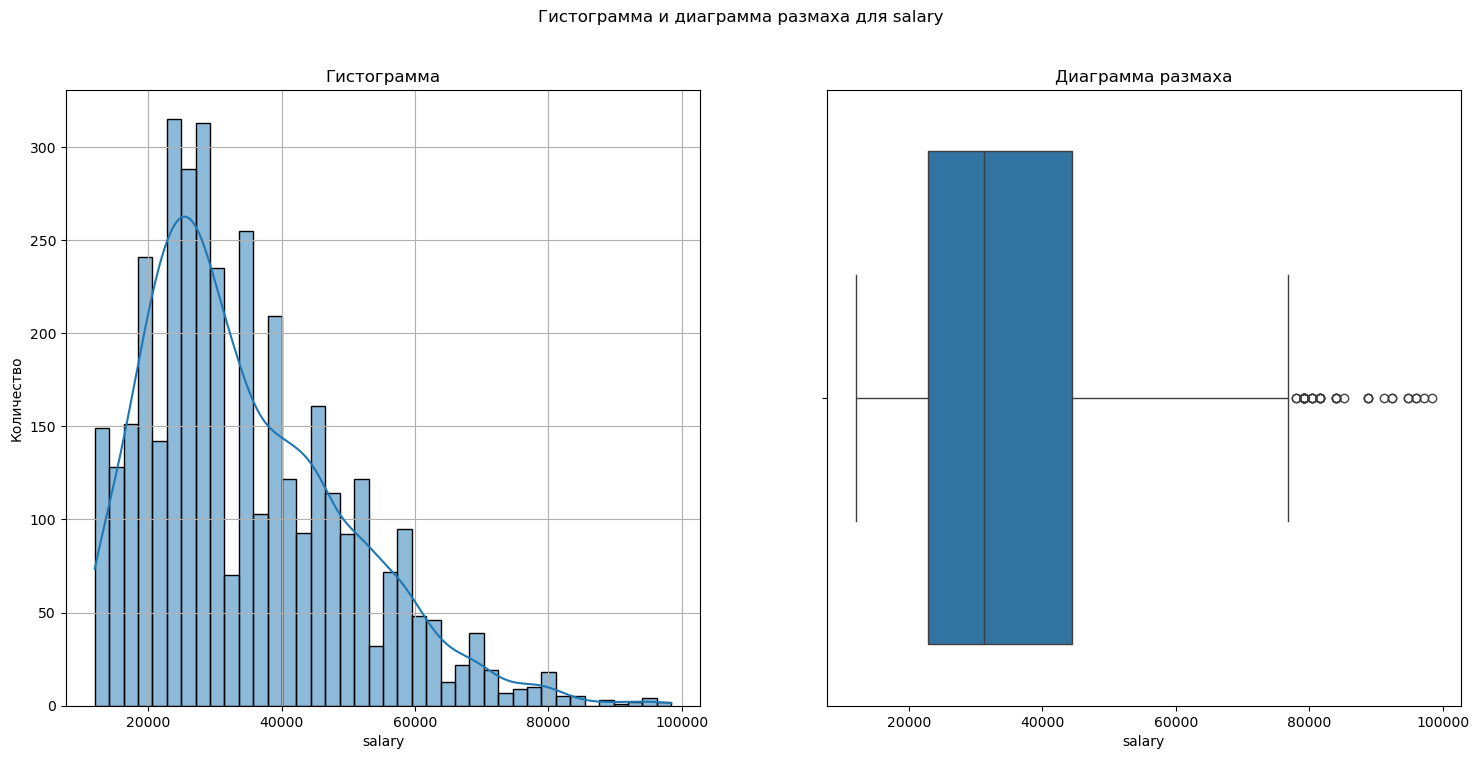

count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


In [18]:
hist_box(train,'salary')

 **Заработная плата (salary):** медиана равна 31200, среднее 34457, стандартное отклонение 15050. Поскольку медиана меньше среднего, это указывает на положительное скошивание (правостороннее), что мы и наблюдаем на гистограмме. Это означает, что в распределении заработных плат есть несколько высоких значений (высоких зарплат), которые "тянут" среднее значение вверх. Большинство сотрудников зарабатывают меньше среднего. Стандартное отклонение в 15055 говорит о том, что заработные платы варьируются значительно относительно среднего значения. Действительно, зарплата варьируется от 12000 до 98400. Таким образом, мы видим разнообразие в заработной плате среди сотрудников. 

На диаграмме размаха видны выбросы, но их значения не выглядят аномальными. Оставим их.

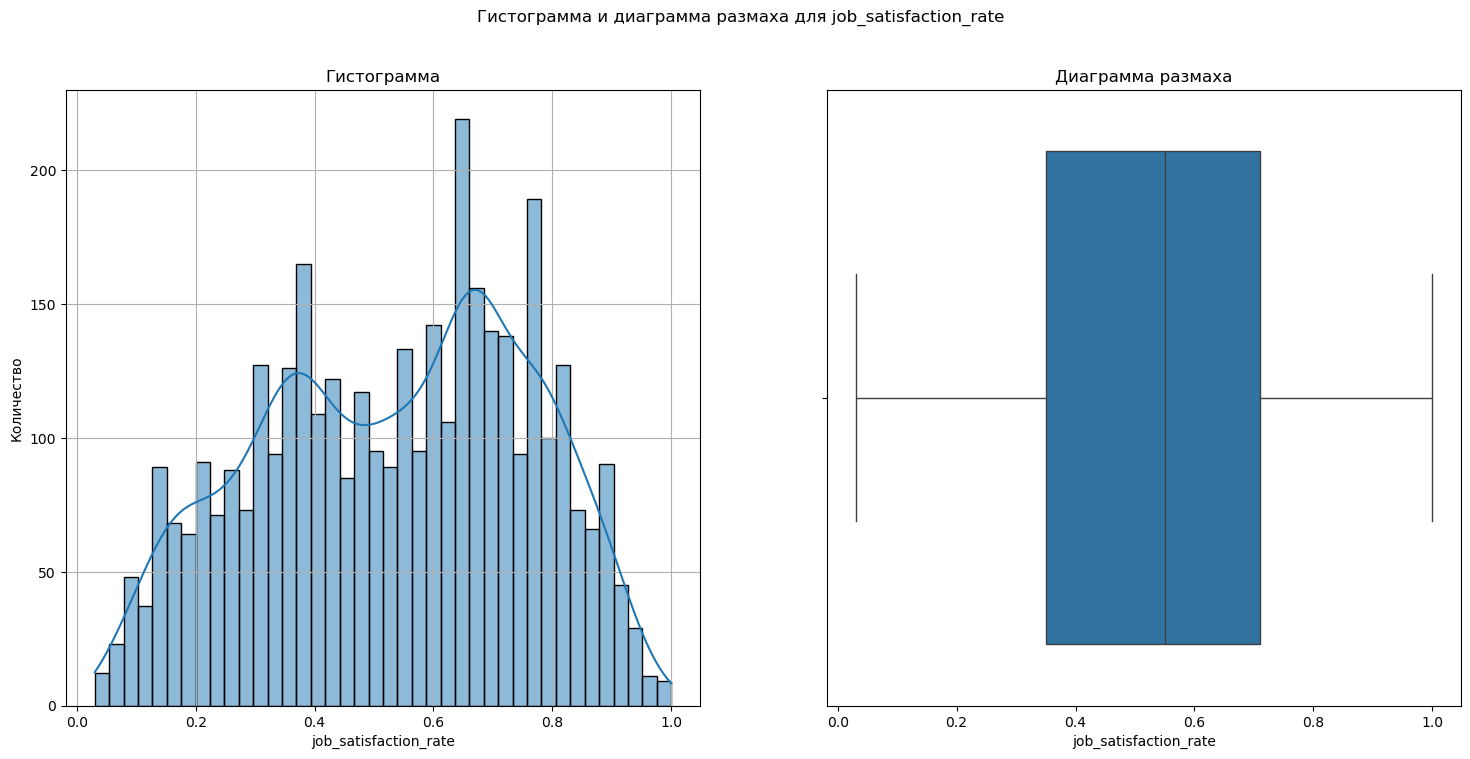

count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [19]:
hist_box(train,'job_satisfaction_rate')

**Уровень удовлетворенности сотрудников (job_satisfaction_rate):** медиана равна 0.55, среднее 0.53, стандартное отклонение 0.23. Медиана и среднее близки, а значит данные примерно равномерно распределены по обе стороны от центральной точки, то есть количество значений выше и ниже среднего примерно одинаково. Стандартное отклонение в 0.23 говорит о том, что существует значительное разнообразие в уровне удовлетворенности среди сотрудников. Это может указывать на то, что некоторые сотрудники очень довольны своей работой, в то время как другие испытывают значительное недовольство.

Действительно, на гистограмме мы видим два пика: 0.39 и 0.64. Бимодальность может указывать на наличие двух различных групп сотрудников с разными уровнями удовлетворенности. Например, одна группа может быть довольна своей работой (пик на уровне 0.64), в то время как другая группа может испытывать значительное недовольство (пик на уровне 0.39). Это может происходить из-за различий в условиях труда, управлении, корпоративной культуре или других факторах.

Таким образом, мы видим неоднородность в рабочей среде или культуре компании. Возможно, некоторые подразделения или команды имеют более позитивный климат, чем другие, что отражается в их уровне удовлетворенности. В данном случае нужен более глубокий анализ. Например, стоит рассмотреть, какие именно факторы влияют на удовлетворенность сотрудников в каждой из групп и как можно улучшить ситуацию для тех, кто находится в нижней части распределения.

На диаграмме размаха выбросов нет.

**Проанализируем категориальные признаки.**

In [20]:
def bar_plot(df, column):
    plt.figure(figsize=(9, 6))
    ax = sn.countplot(x=column, data=df, color='skyblue')

    total = len(df) 
    for p in ax.patches:
        height = p.get_height()  # Высота столбца
        percentage = (height / total) * 100  # Вычисление процента
        ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom')

    plt.title(f'Столбчатая диаграмма для {column}')
    plt.xlabel(f'Значения {column}')
    plt.ylabel('Количество наблюдений')
    plt.grid(True)
    plt.show()

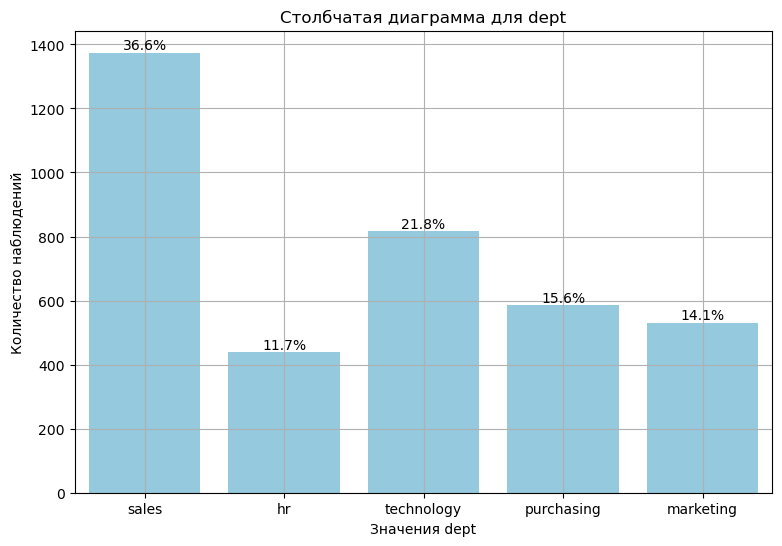

In [21]:
bar_plot(train, 'dept')

Самый многочисленный отдел Sales с 36.5% сотрудников, вероятно деятельность компания имеет сильный акцент на продажах,  самый малочисленный отдел - HR с 11.7%.

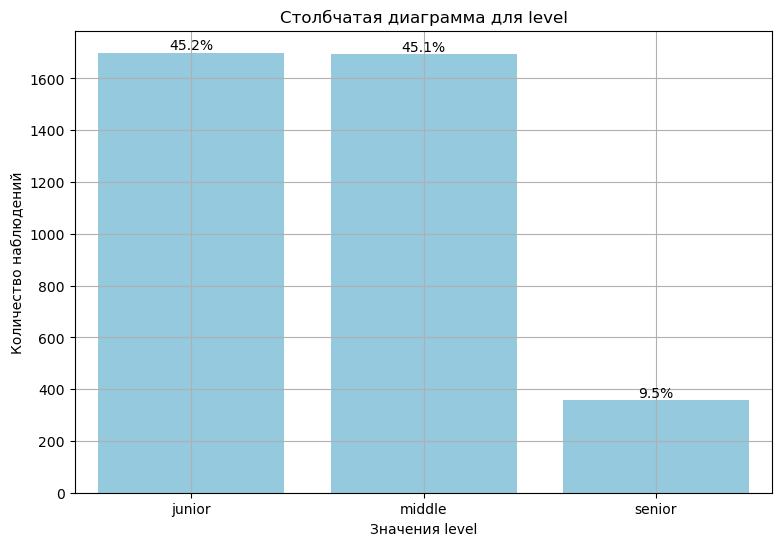

In [22]:
bar_plot(train, 'level')

Самый распространенный уровень 'junior' 45.3%, далее идет middle c 45.2% и senior c 9.5%. Это может указывать на то, что компания активно нанимает молодых специалистов или стажеров, что может быть связано с стратегией роста и развития, однако уровень опытных специалистов уровня 'middle' тоже достаточно высок. На каждого Senior специалиста приходится более 9 сотрудников уровней Middle или Junior. Это может быть связано со спецификой компании или указывать на высокую текучесть кадров среди Senior специалистов.

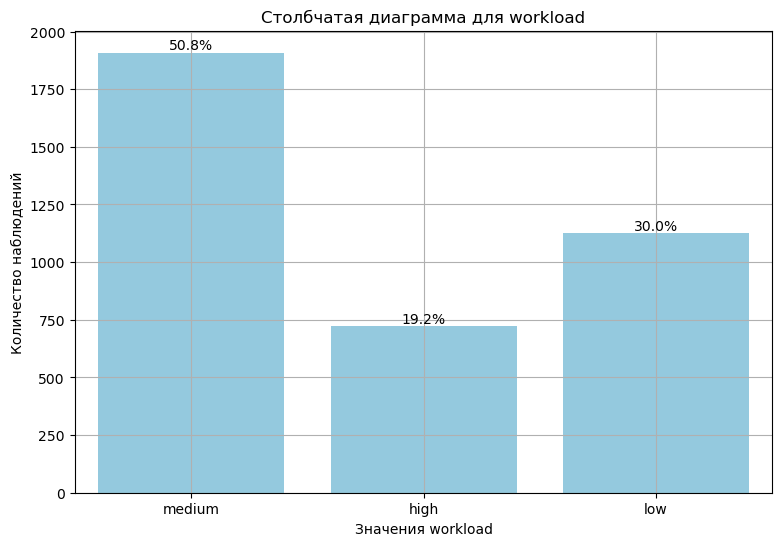

In [23]:
bar_plot(train, 'workload')

Самый распространенный уровень загрузки 'medium' наблюдается у большинства сотрудников 50.8%, далее идет 'high' c 19.2% и 'low' c 30%. Таким образом, значительная часть сотрудников не загружена работой. Это может быть как положительным, так и отрицательным моментом. С одной стороны, это может дать возможность для развития и повышения квалификации сотрудников, с другой — указывать на возможные проблемы с распределением задач или недостаток проектов.

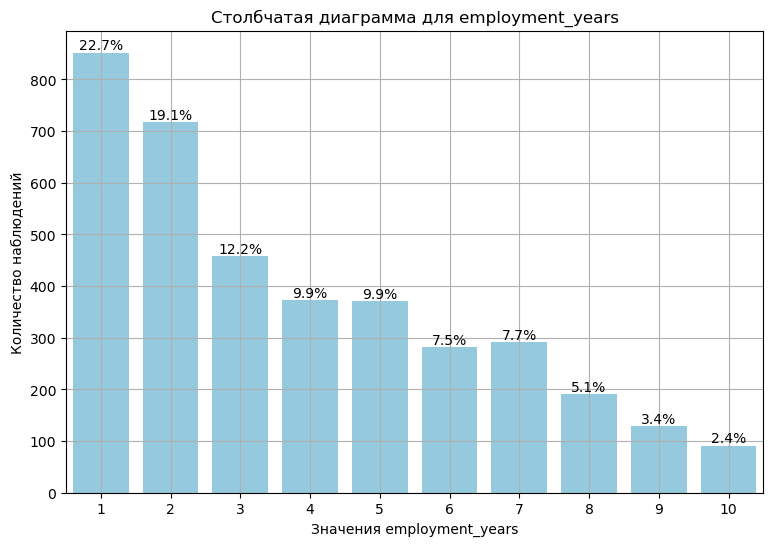

In [24]:
bar_plot(train, 'employment_years')

Медиана равна 3м годам, а среднее - 3.8 лет. Скорее всего, в выборке есть несколько сотрудников, которые проработали в компании значительно дольше, чем большинство, длительность работы принимает значения от 1 до 10 лет. Стандартное отклонение довольно большое 2.6 лет, что говорит о разнообразии в длительности работы сотрудников.

Почти четверть сотрудников (22.6%) работает в компании всего 1 год, что может указывать на высокую текучесть кадров. 

Процент сотрудников уменьшается с увеличением стажа: 19% работают 2 года, 12% — 3 года. 

Долгосрочных сотрудников очень мало — только 2% имеют стаж 10 лет. Существует небольшая группа, работающая от 4 до 7 лет, но и они могут покидать компанию.

Всего 5.8% сотрудников работают более 8 лет, что может указывать на низкую привлекательность компании для долгосрочной работы. В целом, структура стажа указывает на трудности с удержанием сотрудников и необходимость изучения причин текучести кадров.

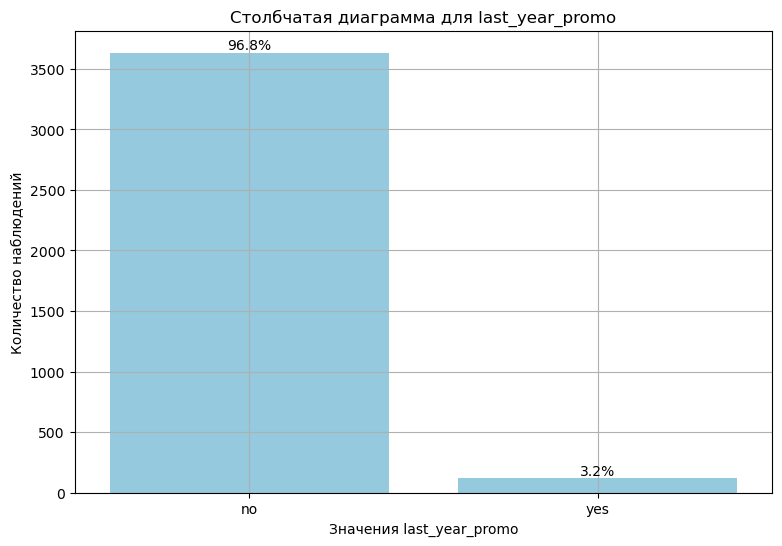

In [25]:
bar_plot(train, 'last_year_promo')

За последний год только 3% сотрудников получали повышение, остальные 97% - нет. Это может указывать на то, что в компании ограниченные возможности для карьерного роста, либо отсутвует четкий и прозрачный карьерный трек, отсутствует культура пересмотра должности и зарплаты, либо политика повышения зарплат и продвижения по службе очень строгая, либо причина в том, что в компании очень много сотрудников на начинающих позициях.

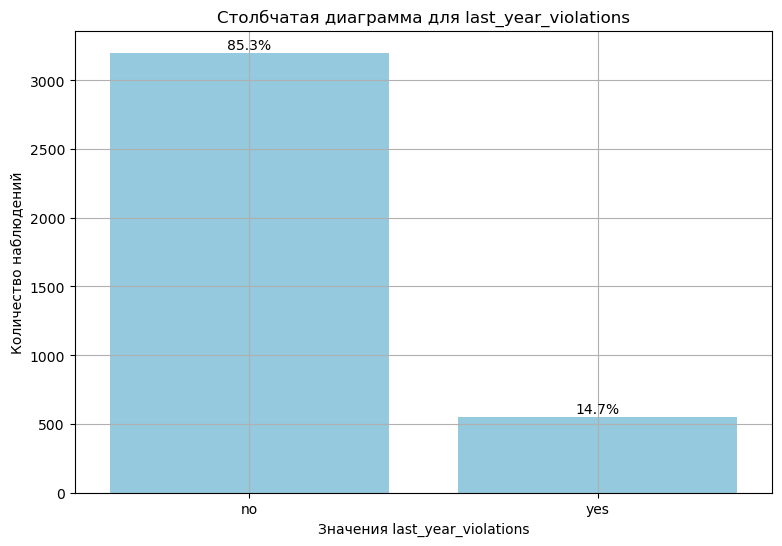

In [26]:
bar_plot(train, 'last_year_violations')

Нарушение трудового договора имели 14.7% сотрудников. Возможно, трудовой договор имеет очень жесткие рамки, либо неясные условия. Возможно, компания не предоставляет достаточного обучения или информации о том, как правильно исполнять свои обязанности в соответствии с трудовым договором. Это может привести к нарушениям, которые происходят неумышленнно из-за недостатка информации.

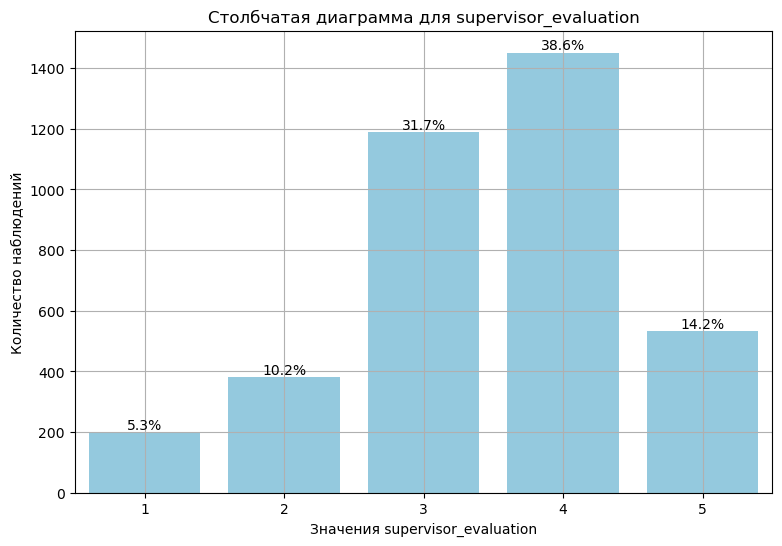

In [27]:
bar_plot(train, 'supervisor_evaluation')

Медианная оценка равна 4 с небольшим стандартных отклонением 1.

Самая распространенная оценка качества работы сотрудников - 4 (у 38.6%), у 31.7% сотрудников оценка 3, у 14.2% сотрудников оценка 5, а оценки 2 и 1 имеют 10.2% и 5.3% сотрудников соответственно.
То, что 15.5% сотрудников (оценки 2 и 1) демонстрируют низкую производительность, требует внимания и более глубокого анализа. Треть работников (31.7%) оцениваются на среднем уровне (3), что указывает на возможность повышения их потенциала.

Итак,
 
медианная заработная плата составляет 31200, в компании значительное разнообразии зарплат среди сотрудников, варьирующихся от 12000 до 98400. На диаграмме размаха видны выбросы, но их значения не выглядят аномальными, поэтому мы оставили их. 

Есть неоднородность в уровне удовлетворенности сотрудников 'job_satisfaction_rate'. Возможно, некоторые подразделения или команды имеют более позитивный опыт, чем другие. В данном случае нужен более глубокий анализ.

Самый многочисленный отдел Sales с 36.5% сотрудников, вероятно деятельность компания имеет сильный акцент на продажах,  самый малочисленный отдел - HR с 11.4%.

Самый распространенный уровень 'junior' 45.3%, далее идет middle c 45.2% и senior c 9.5%. Это может указывать на то, что компания активно нанимает молодых специалистов или стажеров, что может быть связано с стратегией роста и развития,  на каждого Senior специалиста приходится более 10 сотрудников уровней Middle или Junior, что может указывать на недостаток специалистов с высоким уровнем компетенций. 

Почти четверть сотрудников (22.6%) работает в компании всего 1 год, что может указывать на высокую текучесть кадров. Процент сотрудников уменьшается с увеличением стажа, что свидетельствует о вероятно низкой привлекательности компании для долгосрочной работы. В целом, структура стажа указывает на проблемы с удержанием сотрудников и необходимость изучения причин текучести кадров.

За последний год только 3% сотрудников получали повышение, остальные 97% - нет. Это может указывать на то, что в компании ограниченные возможности для карьерного роста: отсутвует четкий и прозрачный карьерный трек, либо строгая политика повышения зарплат и т.д.

Нарушение трудового договора имели 15% сотрудников. Возможно, трудовой договор имеет очень жетские рамки, либо неясные условия. 

Самая распространенная оценка качества работы сотрудников - 4 (у 38.6%), у 31.7% сотрудников оценка 3, что указывает на возможность повышения их потенциала, у 14.2% сотрудников оценка 5, а низкие оценки 2 и 1 имеют 10.2% и 5.3% сотрудников соответственно, что требует внимания и более глубокого анализа.

### Проведем исследовательский анализ данных для X_test.

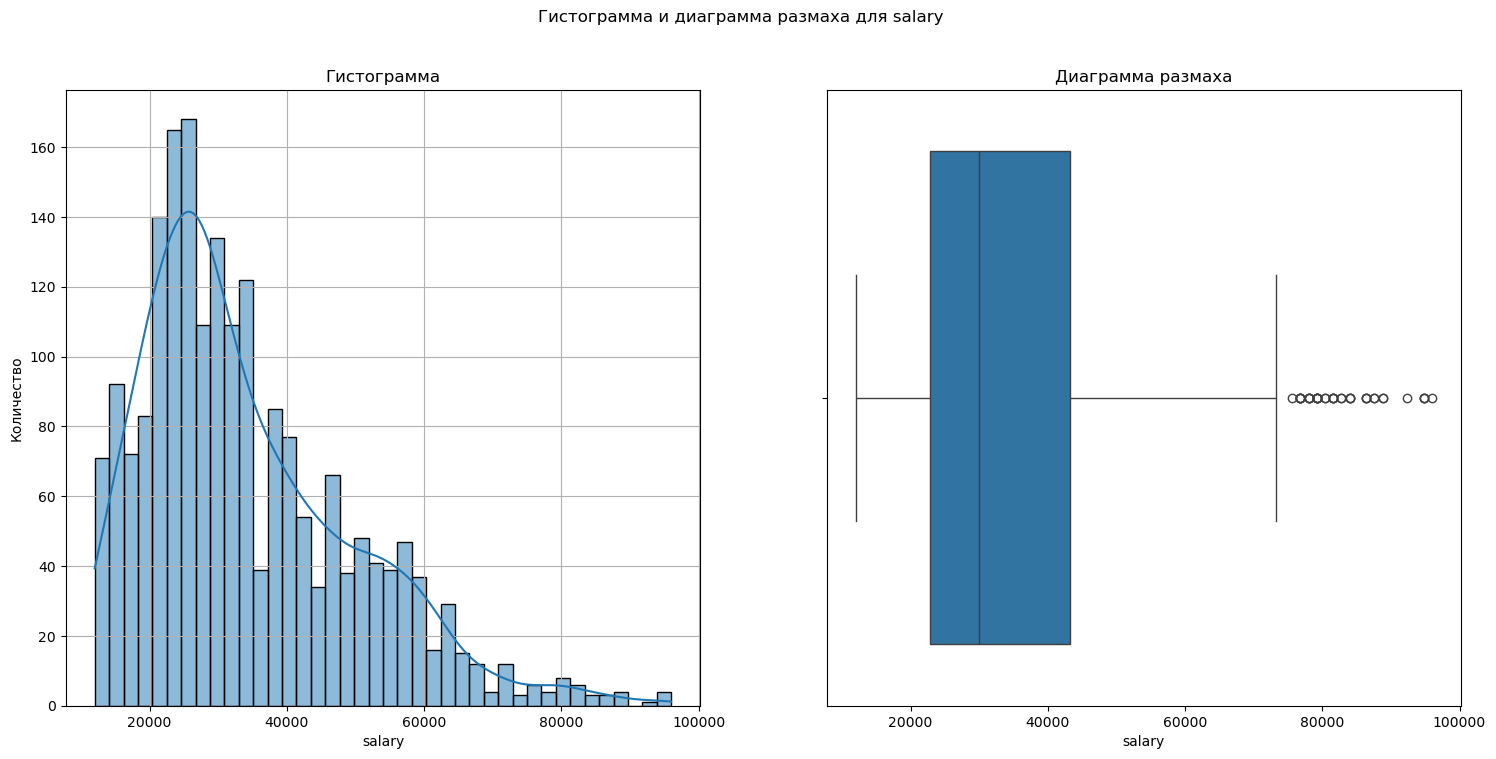

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [28]:
hist_box(X_test,'salary')

**Заработная плата (salary):** медиана равна 30000, среднее 34066, стандартное отклонение 15398 , что примерно соответсвует статистике тренировочной выборки с такой же медианой и чуть более менее средним 33927 и стандартным отклонением 14900.

На диаграмме размаха видны выбросы, но их значения не выглядят аномальными. Оставим их.

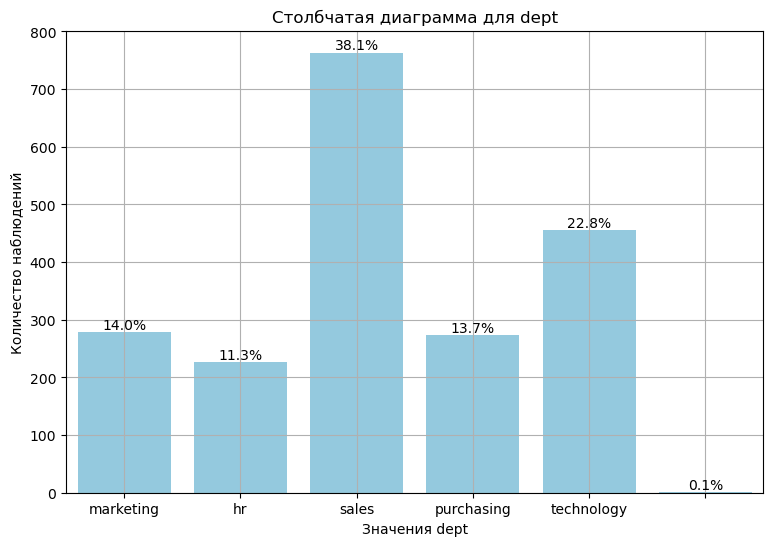

In [29]:
bar_plot(X_test,'dept')

В тестовом датасете X_test сотрудники распределены по отделам примерно также, как в тренировочном датасете: 38.1% сотрудников заняты в самом многочисленном отделе Sales, самый малочисленный отдел - HR с 11.3%.

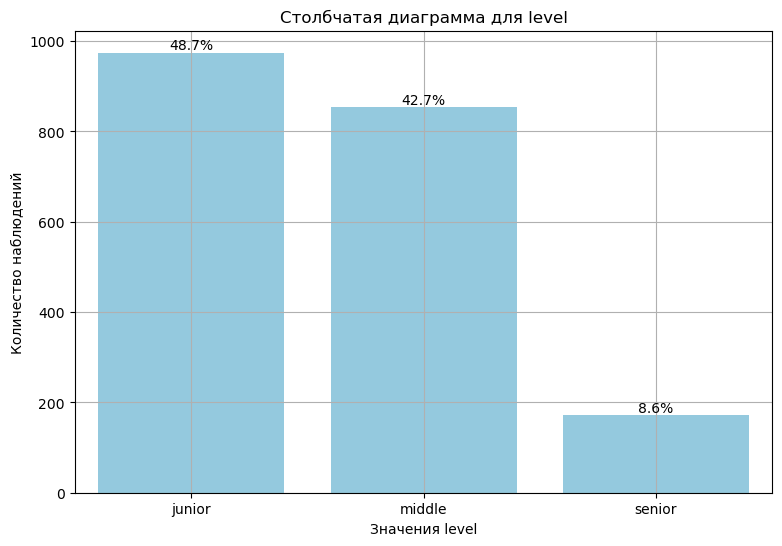

In [30]:
bar_plot(X_test,'level')

Распредение уровней занимаемой должности примерно такое же, как в тренировочной выборке (численность каждой группы отличается не более, чем на 1.5%).

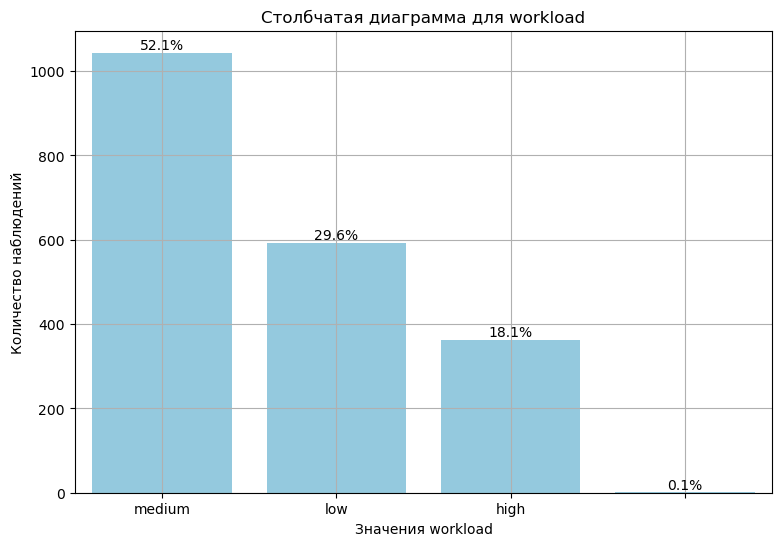

In [31]:
bar_plot(X_test,'workload')

Распредение уровней занимаемой должности примерно такое же, как в тренировочной выборке (численность каждой группы отличается не более, чем на 0.5%).

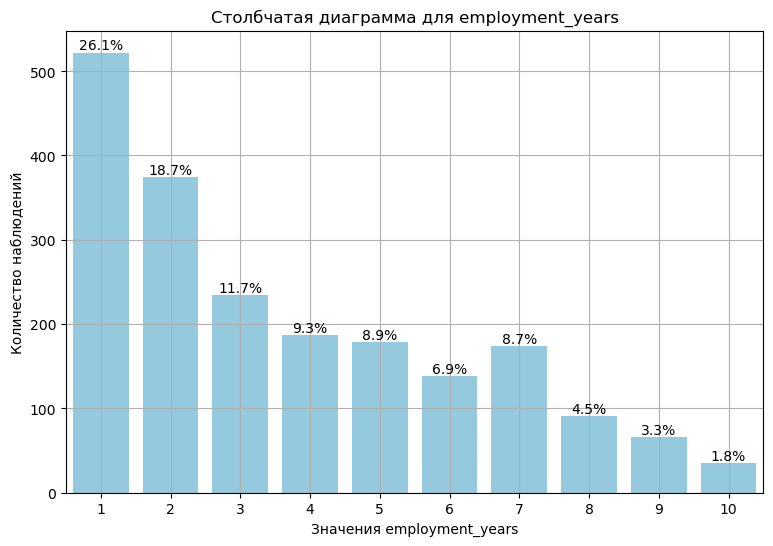

In [32]:
bar_plot(X_test,'employment_years')

Распредение уровней занимаемой должности примерно такое же, как в тренировочной выборке. Доли каждой группы в тренировочной и тестовой выборках отличаются не более, чем на 1.5%. Статистические показатели одинаковы.

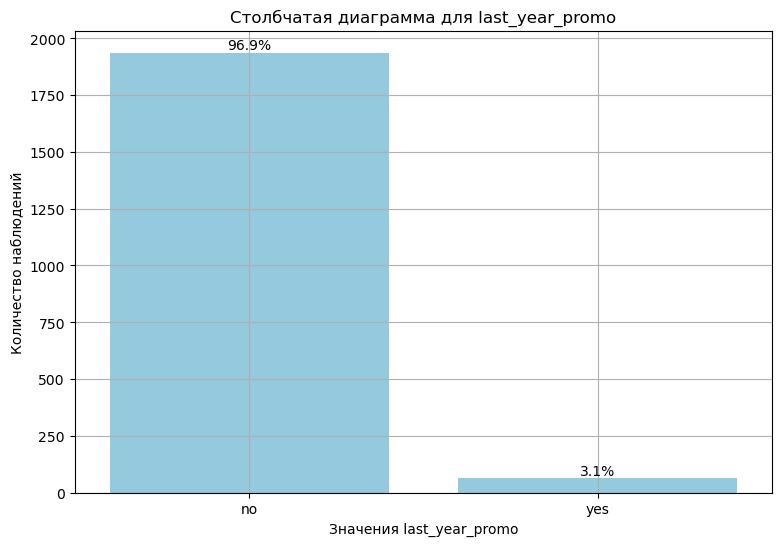

In [33]:
bar_plot(X_test,'last_year_promo')

Распредение повышений сотрудников за последний год примерно такое же, как в тренировочной выборке (различается на 0.1%).

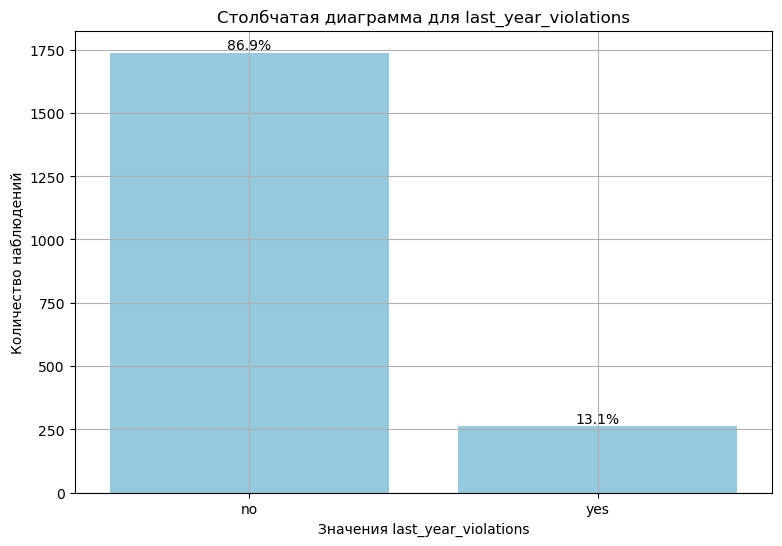

In [34]:
bar_plot(X_test,'last_year_violations')

Распределение повышений сотрудников за последний год примерно такое же, как в тренировочной выборке (различается не более, чем на 1%).

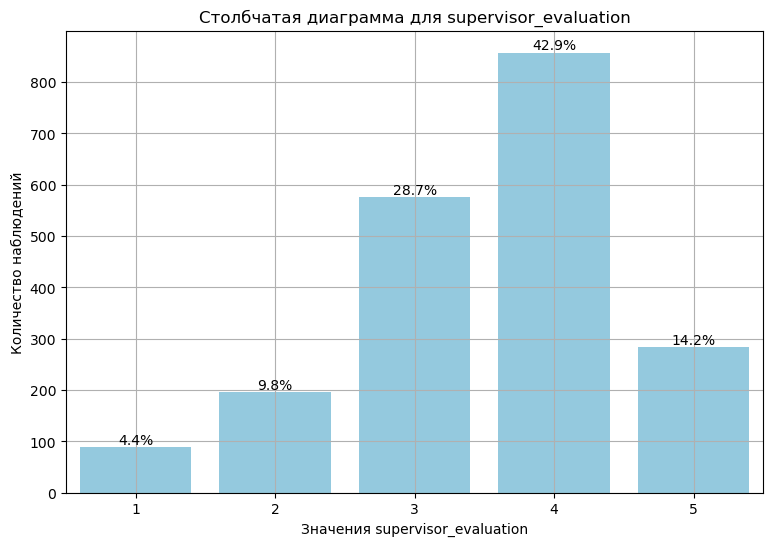

In [35]:
bar_plot(X_test,'supervisor_evaluation')

Медианная оценка равна 4 с небольшим стандартных отклонением 1, аналогично тренировочному датасету.
Распредение повышений сотрудников за последний год примерно такое же, как в тренировочном датасете (различается не более, чем на 3%).

**Вывод:** Было проведено сравнение тестового и тренировочного датасета - сильных отличий нет, выбросов и аномалий в данных не обнаружено.  

### Корреляционный анализ

Проведем корреляционный анализ признаков. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

In [36]:
phik_corr = train.drop(['id'], axis = 1).phik_matrix(
    interval_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'salary',
    'job_satisfaction_rate'
]
) 
phik_corr

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.000000,0.000000,0.018079,0.025931,0.000000,0.000000,0.100579,0.270239,0.074739
level,0.000000,1.000000,0.404459,0.675467,0.100352,0.000000,0.000000,0.714411,0.077260
workload,0.018079,0.404459,1.000000,0.165879,0.057938,0.000000,0.037565,0.785277,0.043958
employment_years,0.025931,0.675467,0.165879,1.000000,0.180832,0.043766,0.000000,0.469992,0.319331
last_year_promo,0.000000,0.100352,0.057938,0.180832,1.000000,0.011274,0.016247,0.211173,0.191464
last_year_violations,0.000000,0.000000,0.000000,0.043766,0.011274,1.000000,0.183221,0.000000,0.566993
supervisor_evaluation,0.100579,0.000000,0.037565,0.000000,0.016247,0.183221,1.000000,0.000000,0.762964
salary,0.270239,0.714411,0.785277,0.469992,0.211173,0.000000,0.000000,1.000000,0.149599
job_satisfaction_rate,0.074739,0.077260,0.043958,0.319331,0.191464,0.566993,0.762964,0.149599,1.000000


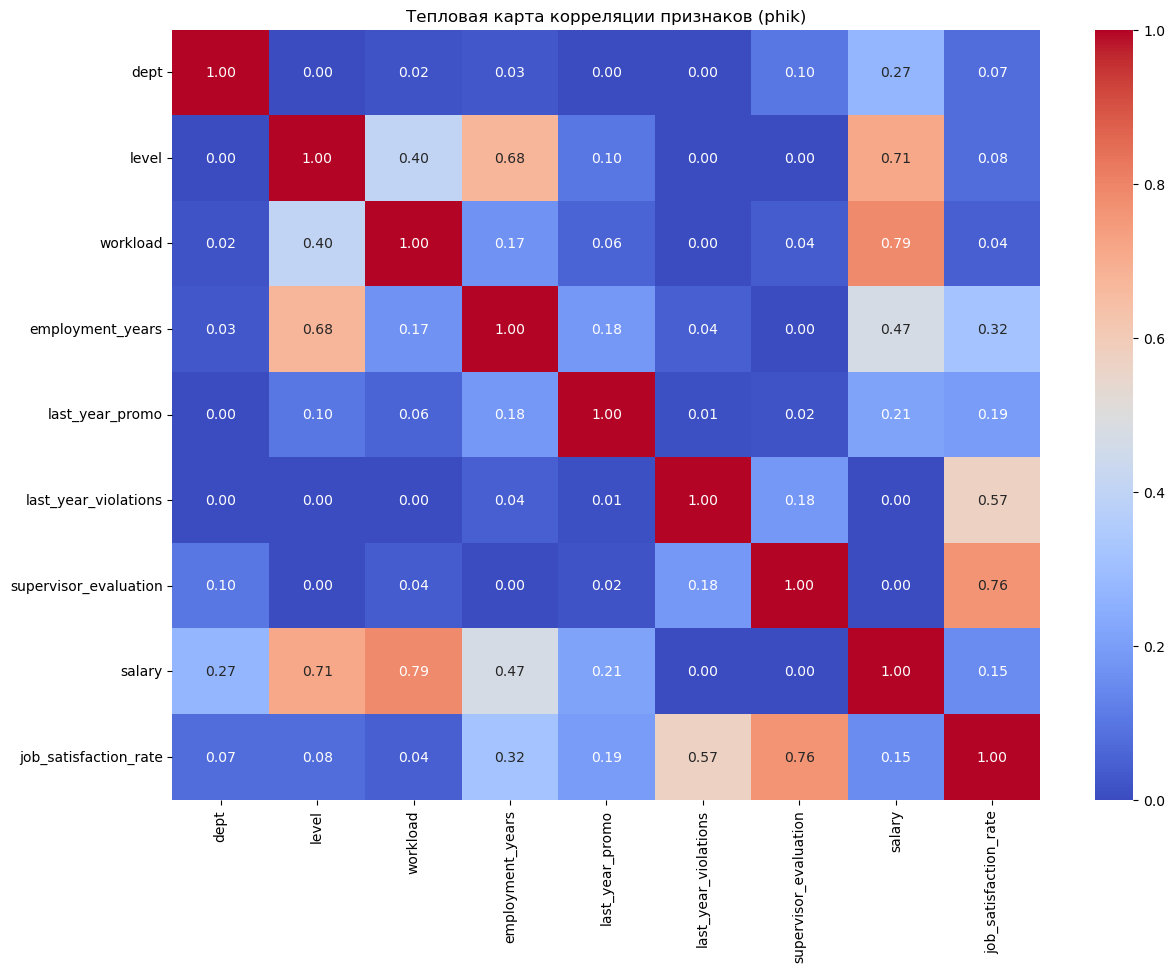

In [37]:
plt.figure(figsize=(14, 10))
sn.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции признаков (phik)')
plt.show()

Между признаками наблюдается:


Сильная корреляция (значения выше 0.7):

* 0.79 - 'salary' и 'workload' 

* 0.76 - 'supervisor_evaluation' и 'job_satistfaction_rate'

* 0.71 - 'salary' и 'level'


Умеренная корреляция (значения от 0.4 до 0.7):

* 0.68 -'employment_years' и 'level'

* 0.57 -'last_year_violations' и 'job_satistfaction_rate'
* 0.48 - 'salary' и 'employment_years'
* 0.42 - 'level' и 'workload'

Слабая корреляция или отсутствие корреляции для остальных признаков.

**Вывод:** 
Медианная заработная плата составляет 31200, в компании значительное разнообразии зарплат среди сотрудников, варьирующихся от 12000 до 98400. На диаграмме размаха видны выбросы, но их значения не выглядят аномальными, поэтому мы оставили их. 

Есть неоднородность в уровне удовлетворенности сотрудников 'job_satisfaction_rate'. Возможно, некоторые подразделения или команды имеют более позитивный опыт, чем другие. В данном случае нужен более глубокий анализ.

Самый многочисленный отдел Sales с 36.5% сотрудников, вероятно деятельность компания имеет сильный акцент на продажах,  самый малочисленный отдел - HR с 11.4%.

Самый распространенный уровень 'junior' 45.3%, далее идет middle c 45.2% и senior c 9.5%. Это может указывать на то, что компания активно нанимает молодых специалистов или стажеров, что может быть связано с стратегией роста и развития,  на каждого Senior специалиста приходится более 10 сотрудников уровней Middle или Junior, что может указывать на недостаток специалистов с высоким уровнем компетенций. 

Почти четверть сотрудников (22.6%) работает в компании всего 1 год, что может указывать на высокую текучесть кадров. Процент сотрудников уменьшается с увеличением стажа, что свидетельствует о вероятно низкой привлекательности компании для долгосрочной работы. В целом, структура стажа указывает на проблемы с удержанием сотрудников и необходимость изучения причин текучести кадров.

За последний год только 3% сотрудников получали повышение, остальные 97% - нет. Это может указывать на то, что в компании ограниченные возможности для карьерного роста: отсутвует четкий и прозрачный карьерный трек, либо строгая политика повышения зарплат и т.д.

Нарушение трудового договора имели 15% сотрудников. Возможно, трудовой договор имеет очень жетские рамки, либо неясные условия. 

Самая распространенная оценка качества работы сотрудников - 4 (у 38.6%), у 31.7% сотрудников оценка 3, что указывает на возможность повышения их потенциала, у 14.2% сотрудников оценка 5, а низкие оценки 2 и 1 имеют 10.2% и 5.3% сотрудников соответственно, что требует внимания и более глубокого анализа.

Для тестовых данных ситуация схожая.

Провели корреляционный анализ признаков. Выявили сильную корреляцию между признаками 'salary' и 'workload' (0.79), 'supervisor_evaluation' и 'job_satistfaction_rate' (0.76). Тем не менее, корреляция не превышает 0.8, поэтому оставляем все признаки.

## Шаг 4. Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

Установим в качестве индекса id сотрудника.

In [38]:
train.set_index('id', inplace=True)
X_test.set_index('id', inplace=True)
y_test.set_index('id', inplace=True)

In [39]:
y_train = train['job_satisfaction_rate']
X_train = train.drop('job_satisfaction_rate', axis = 1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3755, 8)
(3755,)
(2000, 8)
(2000, 1)


In [40]:
ohe_columns = ['dept',  'level', 'last_year_promo', 'last_year_violations']
ord_columns = ['workload', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary']

cat_list = ['dept',  'level', 'last_year_promo', 'last_year_violations','workload', 'supervisor_evaluation']

In [41]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
        
    ]
)
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

(
            'ord',  
            OrdinalEncoder(
                categories='auto', 
                handle_unknown='use_encoded_value',
                unknown_value=6
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [ 
        ('num', MinMaxScaler(), num_columns),
        ('cat', ord_pipe, cat_list)
    ], 
    remainder='passthrough'
) 

**Вывод: Был установлен id в качестве индекса, были подготовлены тестовая и тренировочная выборка, был создан пайплайн, учитывающий особенности признаков при кодировании**

## Шаг 5. Обучение моделей

### Напишем функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE.

In [42]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # избегаем деления на ноль, заменяя нули на единицы
    denominator[denominator == 0] = 1
    return (100 / len(y_true)) * np.sum(np.abs(y_pred - y_true) / denominator)

In [43]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

### Обучим три модели (линейную модель, дерево решений, ридж-регрессию) со следующими гиперпараметрами:

In [44]:
param_grid = [
    
        # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__cat': [ohe_pipe]  
    },
    # словарь для модели DecisionTreeClassifier()
        {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,12),
        'models__max_features': range(7,15)
    },
    # словарь для модели CatBoostClassifier()
        {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)],
        'models__max_depth': range(5,12),
        'models__iterations': [500, 1000],
        'models__learning_rate': [0.05, 0.1, 0.15, 0.2]
    },
        {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300, 500],
        'models__max_depth': [ 10, 12, 15, 20],
        'models__learning_rate':[ 0.1, 0.2, 0.5, 0.75 ]
    }

]

In [45]:
smape_scorer = make_scorer(smape, greater_is_better=False)

### Обучим модели

In [46]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', -randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['employment_years',
                                                   'salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                                  ('simpleImputer_after_ord',
                    

Таким образом, лучшая модель CatBoostRegressor.

Метрика лучшей модели при кросс-валидации: 11.52

In [47]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [48]:
test=X_test.join(y_test, how='outer')
test.shape

(2000, 9)

In [49]:
test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80
100480,marketing,junior,low,4,no,no,4,16800,0.84
100503,purchasing,middle,high,5,no,no,4,55200,0.79
100610,sales,middle,medium,5,no,no,4,43200,0.75
100692,sales,middle,high,6,no,no,4,48000,0.69


In [50]:
y_test = test['job_satisfaction_rate']
X_test = test.drop('job_satisfaction_rate', axis = 1)

In [51]:
best_model = randomized_search.best_estimator_
y_test_pred = best_model.predict(X_test)
smape_test = smape(y_test, y_test_pred)
print('Метрика SMAPE на тестовой выборке для лучшей модели:', smape_test)

Метрика SMAPE на тестовой выборке для лучшей модели: 10.613853964682495


Метрика SMAPE=10.6 на тестовой выборке, а значит условие SMAPE ≤15 выполнено.

**Вывод:** Была написана функция для подсчета метрики SMAPE. В данном случае удобно использовать эту метрику, так как это симметричная метрика, которая одинаково штрафует как положительные, так и отрицательные ошибки. MAPE может быть чувствительной к нулевым значениям в фактических данных, так как деление на ноль не определено, либо может давать слишком большие слагаемые. Поскольку SMAPE использует среднее значение фактических и прогнозируемых значений в знаменателе, она менее чувствительна к выбросам.

## Шаг 6. Промежуточные выводы по задаче 1


Были выбраны четыре модели: линейная модель, дерево решений, CatBoost, LGBM. Линейная модель удобна своей простотой и интерпретируемостью, дерево решений лучше работает в ситуациях с нелинейными зависимостями,  а CatBoost и LightGBM обеспечивают высокую точность за счёт бустинга, устойчивости к переобучению и автоматической обработки категориальных признаков. Таким образом, использование этих моделей позволяет подойти к решению задачи с разных сторон и найти наиболее оптимальный подход.

В результате лучшей моделью стала CatBoostRegressor. Метрика SMAPE=10.6 на тестовой выборке, а значит условие SMAPE ≤15 выполнено.

# Задача 2

## Шаг 7. Загрузка данных

Загрузим данные

In [52]:
train_new = open_csv('train_quit.csv')
train_new.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [53]:
X_test_new = open_csv('test_features.csv')
X_test_new.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [54]:
y_test_new = pd.read_csv('test_target_quit.csv')
y_test_new.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Вывод: Созданы датафреймы, данные и названия столбцов выглядят корректными.**

## Шаг 8. Предобработка данных

### Проверим наличие пропусков в данных.

Изучим информацию о датафрейме train_new

In [55]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Пропусков нет.

Мы уже анализировали данные датафрейма X_test_new на шаге 2, но на всякий случай проверим еще раз.

In [56]:
X_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В X_test_new есть пропуски. Мы заполним их на этапе Pipeline.

Изучим информацию о новом датафрейм y_test

In [57]:
y_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Пропусков нет.

### Проверим наличие дубликатов в данных.

Проверим, есть ли явные дубликаты.

In [58]:
print("Количество явных дубликатов в train_new:", train_new.duplicated().sum())
print("Количество явных дубликатов в X_test_new:", X_test_new.duplicated().sum())
print("Количество явных дубликатов в y_test_new:", y_test_new.duplicated().sum())

Количество явных дубликатов в train_new: 0
Количество явных дубликатов в X_test_new: 0
Количество явных дубликатов в y_test_new: 0


In [59]:
columns_to_check = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

print('train_new:')
for column in columns_to_check:
    print(f"Уникальные значения в столбце '{column}':", train_new[column].unique())
    
print('X_test_new:')
for column in columns_to_check:
    print(f"Уникальные значения в столбце '{column}':", X_test_new[column].unique())

train_new:
Уникальные значения в столбце 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в столбце 'level': ['middle' 'junior' 'sinior']
Уникальные значения в столбце 'workload': ['high' 'medium' 'low']
Уникальные значения в столбце 'last_year_promo': ['no' 'yes']
Уникальные значения в столбце 'last_year_violations': ['no' 'yes']
X_test_new:
Уникальные значения в столбце 'dept': ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце 'workload': ['medium' 'low' 'high' ' ']
Уникальные значения в столбце 'last_year_promo': ['no' 'yes']
Уникальные значения в столбце 'last_year_violations': ['no' 'yes']


In [60]:
train_new

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


Уберем опечатку в столбце 'level'

In [61]:
train_new['level'] = train_new['level'].replace('sinior', 'senior')
X_test_new['level'] = X_test_new['level'].replace('sinior', 'senior')

 Проверим, что все id уникальны.

In [62]:
# Проверка уникальности значений в столбце 'id'
print("Все значения в столбце 'id' уникальны:", train_new['id'].is_unique)
print("Все значения в столбце 'id' уникальны:", X_test_new['id'].is_unique)
print("Все значения в столбце 'id' уникальны:", y_test_new['id'].is_unique)

Все значения в столбце 'id' уникальны: True
Все значения в столбце 'id' уникальны: True
Все значения в столбце 'id' уникальны: True


In [63]:
train_new.duplicated(subset=[
                        'dept', 'level', 'workload', 
                        'employment_years', 'last_year_promo', 
                        'last_year_violations', 
                        'supervisor_evaluation', 'salary', 'quit'], 
                 keep=False).sum()

2066

In [64]:
train_new = train_new.drop_duplicates(subset=['dept', 'level', 'workload', 
                                        'employment_years', 'last_year_promo', 
                                        'last_year_violations', 
                                        'supervisor_evaluation', 'salary', 'quit'])

In [65]:
len(train)

3755

**Вывод: Проверили наличие пропусков и дубликатов в данных. Данные корректины, дубликаты не найдены, пропуски заполним на этапе пайплайна.**

## Шаг 9. Исследовательский анализ данных

### Проведем исследовательский анализ данных для train_new.

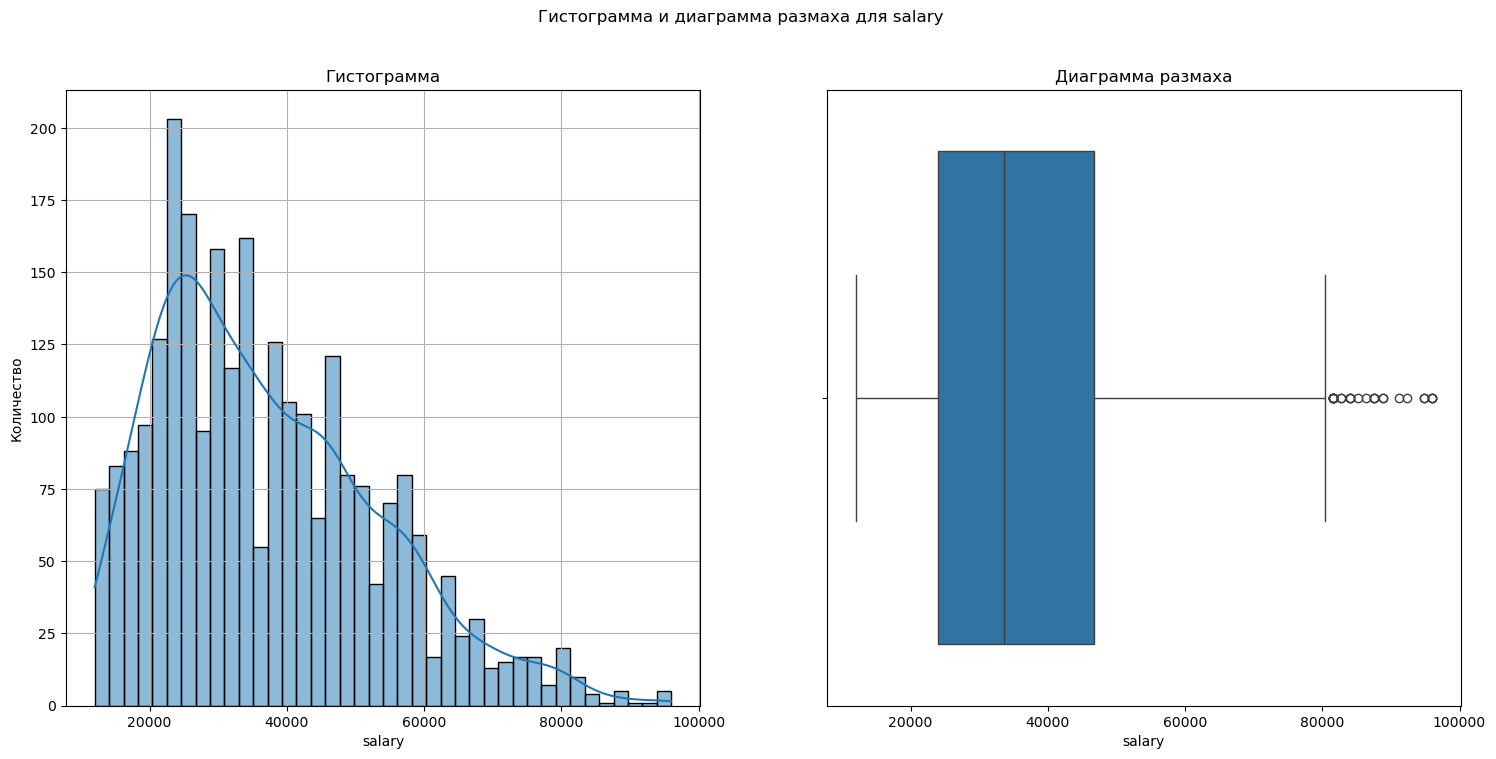

count     2587.000000
mean     37107.692308
std      16267.354906
min      12000.000000
25%      24000.000000
50%      33600.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


In [66]:
hist_box(train_new,'salary')

**Заработная плата (salary):** медиана равна 31200, среднее 34457, стандартное отклонение 15050. Поскольку медиана меньше среднего, это указывает на положительное скошивание (правостороннее), что мы и наблюдаем на гистограмме. Это означает, что в распределении заработных плат есть несколько высоких значений (высоких зарплат), которые "тянут" среднее значение вверх. Большинство сотрудников зарабатывают меньше среднего. Стандартное отклонение в 15055 говорит о том, что заработные платы варьируются значительно относительно среднего значения. Действительно, зарплата варьируется от 12000 до 98400. Таким образом, мы видим разнообразие в заработной плате среди сотрудников. 

На диаграмме размаха видны выбросы, но их значения не выглядят аномальными. Оставим их.

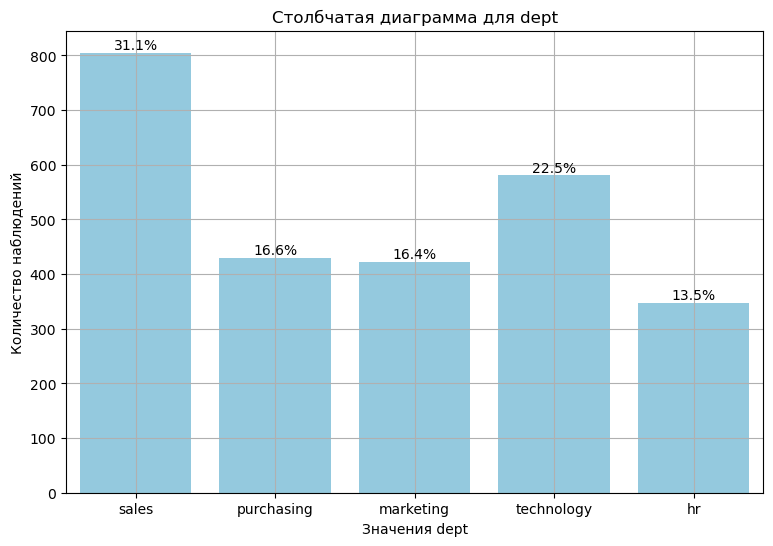

In [67]:
bar_plot(train_new,'dept')

Высокий процент сотрудников в отделе Sales (31.1%) указывает на то, что компания делает акцент на продажах и взаимодействии с клиентами. Значительное количество сотрудников в отделе Technology (22.5%) свидетельствует о том, что компания уделяет внимание технологиям. Примерно равное количество сотрудников в отделах Purchasing и Marketing (16.6% и 16.4%) говорит о том, что компания понимает важность как закупок, так и маркетинга для достижения своих бизнес-целей. Это может указывать на стратегический подход к управлению ресурсами и продвижению товаров или услуг. Наименьшее количество сотрудников в отделе HR (13.5%) может свидетельствовать о том, что кадровым вопросам уделяется недостаточно внимания. 

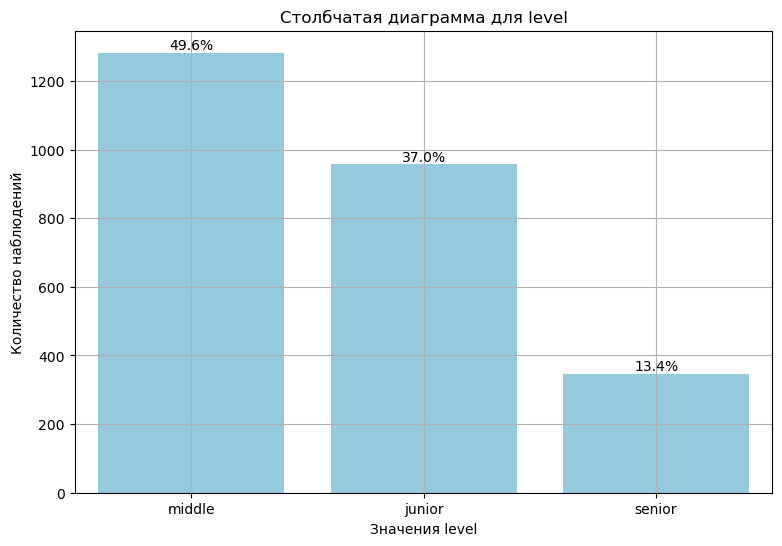

In [68]:
bar_plot(train_new,'level')

Самый распространенный уровень middle 49.6%, далее идет junior c 37% и senior c 13.4%. Присутствие значительного количества сотрудников уровня middle говорит о том, что в компании есть достаточно специалистов со средним опытом, что может обеспечить стабильность и поддержку для новичков.

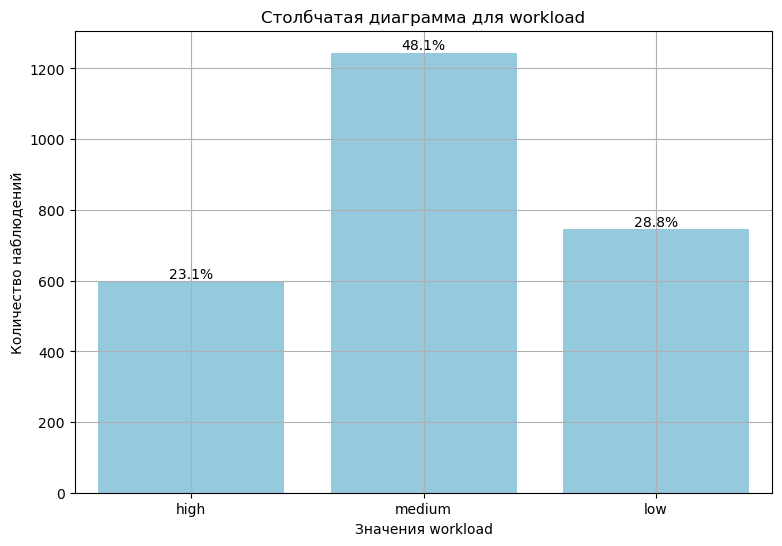

In [69]:
bar_plot(train_new,'workload')

Самый распространенный уровень загрузки 'medium' наблюдается у 48% сотрудников, далее идет 'low' c 29% и 'high' c 23%. Уровень 'high' (23%) может вызывать беспокойство, так как это означает, что значительное количество сотрудников испытывает высокую нагрузку, в то время как 29% сотрудниковв имеют низкую нагрузку.

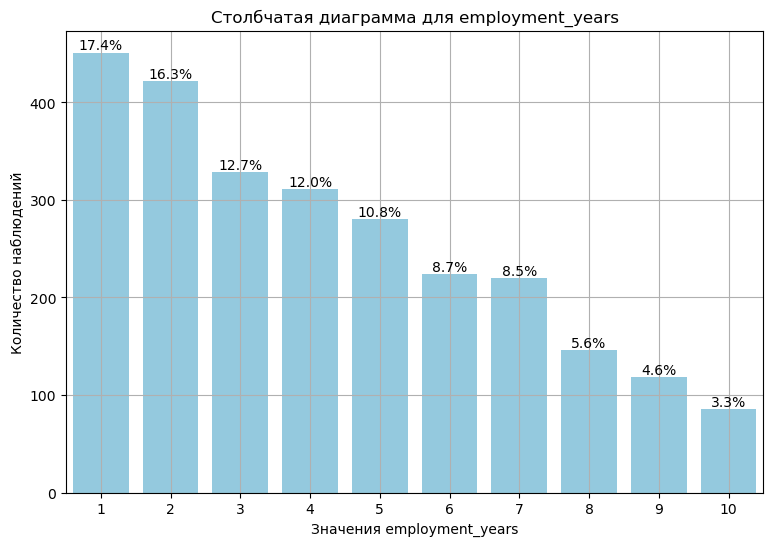

In [70]:
bar_plot(train_new,'employment_years')

Медиана равна 3м годам, а среднее - 3.8 лет. Скорее всего, в выборке есть несколько сотрудников, которые проработали в компании значительно дольше, чем большинство, длительность работы принимает значения от 1 до 10 лет. Стандартное отклонение довольно большое 2.6 лет, что говорит о разнообразии в длительности работы сотрудников.

17.4% сотрудников работает в компании всего 1 год, что может указывать на высокую текучесть кадров.

Процент сотрудников уменьшается с увеличением стажа: 16% работают 2 года, 13% — 3 года.

Долгосрочных сотрудников немного — 3% имеют стаж 10 лет. 

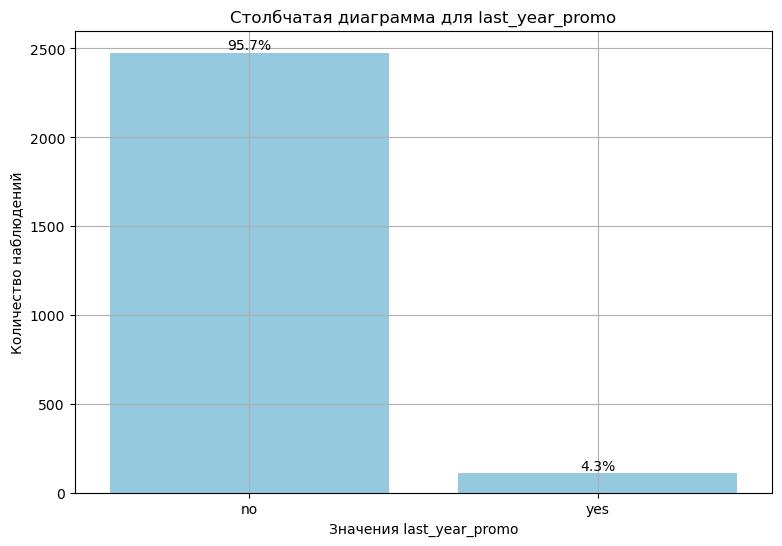

In [71]:
bar_plot(train_new, 'last_year_promo')

За последний год только 4.3% сотрудников получали повышение, остальные 95.7% - нет. Это может указывать на то, что в компании ограниченные возможности для карьерного роста, либо отсутвует четкий и прозрачный карьерный трек, отсутствует культура пересмотра должности и зарплаты, либо политика повышения зарплат и продвижения по службе очень строгая, либо причина в том, что в компании очень много сотрудников на начинающих позициях.

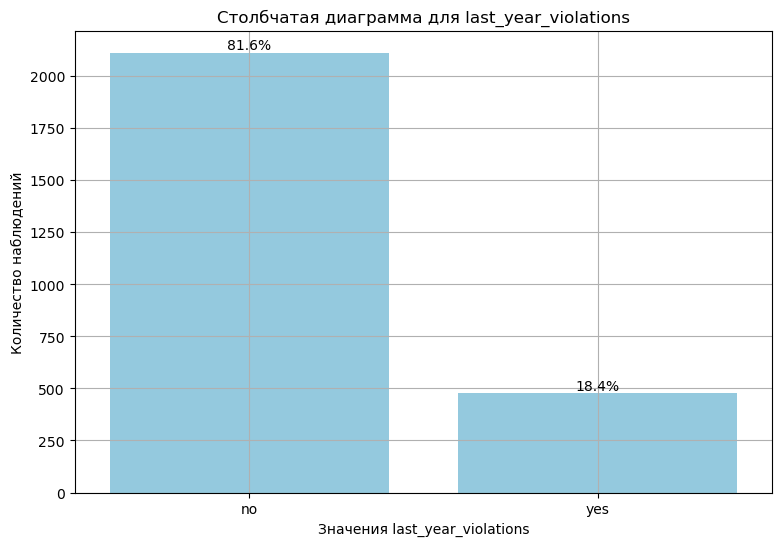

In [72]:
bar_plot(train_new, 'last_year_violations')

Нарушение трудового договора имели 18.4% сотрудников. Возможно, трудовой договор имеет очень жесткие рамки, либо неясные условия. Возможно, компания не предоставляет достаточного обучения или информации о том, как правильно исполнять свои обязанности в соответствии с трудовым договором. Это может привести к нарушениям, которые происходят неумышленнно из-за недостатка информации.

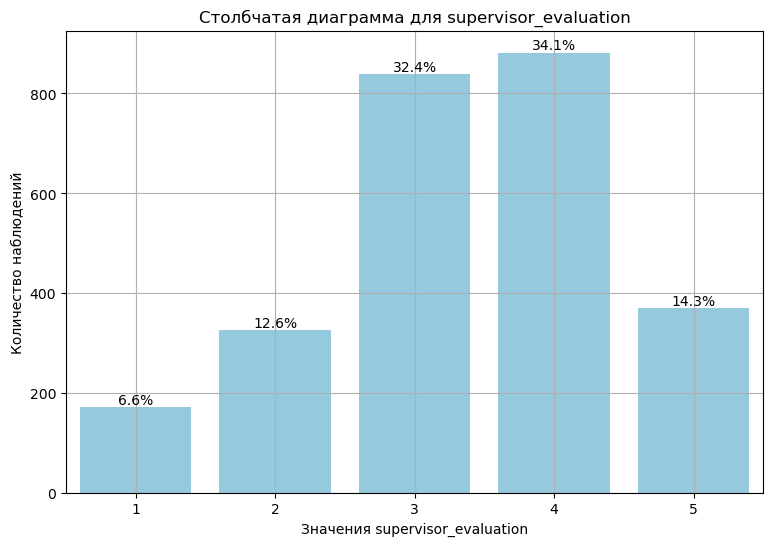

In [73]:
bar_plot(train_new, 'supervisor_evaluation')

Медианная оценка равна 4 с небольшим стандартных отклонением 1.

Самая распространенная оценка качества работы сотрудников - 4 (у 34.1%), у 32.4% сотрудников оценка 3, у 14.3% сотрудников оценка 5, а оценки 2 и 1 имеют 10.2% и 5.3% сотрудников соответственно.
То, что 19.2% сотрудников демонстрируют низкую производительность (оценки 2 и 1), требует внимания и более глубокого анализа. Треть работников (32.4%) оцениваются на среднем уровне (3), что указывает на возможность повышения их потенциала.

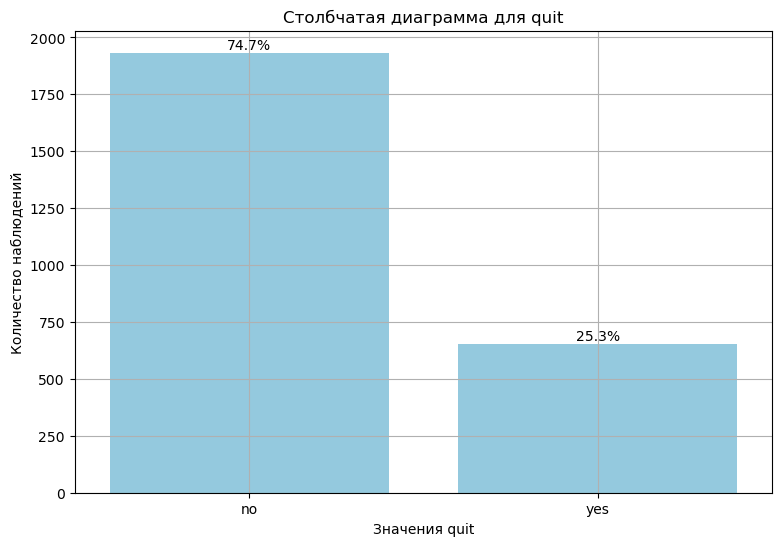

In [74]:
bar_plot(train_new, 'quit')

В компании 25.3% сотрудников уволились.

Таким образом:

Медианная заработная плата составляет 31200, в компании значительное разнообразии зарплат среди сотрудников, варьирующихся от 12000 до 98400. На диаграмме размаха видны выбросы, но их значения не выглядят аномальными, поэтому мы оставили их. 

Самый распространенный уровень middle 49.6%, далее идет junior c 37% и senior c 13.4%. Присутствие значительного количества сотрудников уровня middle говорит о том, что в компании есть достаточно специалистов со средним опытом, что может обеспечить стабильность и поддержку для новичков.

Высокий процент сотрудников в отделе Sales (31.1%) указывает на то, что компания делает акцент на продажах и взаимодействии с клиентами. 

Самый распространенный уровень загрузки 'medium' наблюдается у 48% сотрудников, далее идет 'low' c 29% и 'high' c 23%. Уровень 'high' (23%) может вызывать беспокойство, так как это означает, что значительное количество сотрудников испытывает высокую нагрузку, в то время как 29% сотрудниковв имеют низкую нагрузку.

Медиана стажа равна 3м годам, а среднее - 3.8 лет. Стандартное отклонение 2.6 лет говорит о разнообразии в длительности работы сотрудников.

За последний год только 4.3% сотрудников получали повышение, остальные 95.7% - нет. Это может указывать на то, что в компании ограниченные возможности для карьерного роста, либо отсутвует четкий и прозрачный карьерный трек и т.д.

Нарушение трудового договора имели 18.4% сотрудников. Возможно, трудовой договор имеет очень жесткие рамки, либо неясные условия. 

Медианная оценка качества работы сотрудников равна 4 с небольшим стандартных отклонением 1. То, что 19.2% сотрудников демонстрируют низкую производительность (оценки 2 и 1), требует внимания и более глубокого анализа.

Так как тестовые датасеты для Задачи 1 и Задачи 2 по ТЗ совпадают, то не будем повторять исследовательский анализ данных для X_test_new, его можно найти в шаге 3.

### Составим портрет «уволившегося сотрудника». Узнаем, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности, сравним среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

In [75]:
left_employees = train_new[train_new['quit'] == 'yes']

# Функция для создания сводной таблицы
def summarize_employees(df, group_col):
    total_employees = df[group_col].value_counts()
    left_employees = df[df['quit'] == 'yes'][group_col].value_counts()
    summary = pd.DataFrame({'total_employees': total_employees, 'fired_employees': left_employees}).fillna(0)
    summary['percent_fired'] = (summary['fired_employees'] / summary['total_employees']) * 100
    return summary

columns = ['dept', 'level', 'workload', 'employment_years',
           'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
for column in columns:
    column_summary=summarize_employees(train_new, column)
    print(f"Процент уволенных сотрудников по {column}") 
    print(column_summary,end='\n\n')
    print() 



Процент уволенных сотрудников по dept
            total_employees  fired_employees  percent_fired
dept                                                       
sales                   805              191      23.726708
technology              581              150      25.817556
purchasing              430              120      27.906977
marketing               423              112      26.477541
hr                      348               82      23.563218


Процент уволенных сотрудников по level
        total_employees  fired_employees  percent_fired
level                                                  
junior              958              537      56.054280
middle             1282              101       7.878315
senior              347               17       4.899135


Процент уволенных сотрудников по workload
          total_employees  fired_employees  percent_fired
workload                                                 
high                  597              109      18.257956
low

Таким образом, чаще всего увольняются сотрудники 

 * уровня junior   56%
 * имеющие 1-3 года стажа (61% среди тех, у кого 1 год стажа, 42% - 2 года стажа, 39% - три года стажа )
 * имеющие низкие оценки качества работы 1-3 балла (40% среди тех, у кого 1 балл, 38% - 2 балла, 32% - 3 балла )
 * имеющие низкую нагрузку 'low' (39%)
 * имеющие нарушение трудового договора за последний год (38%)
 * не имеющие повышения за последний год (26%)
 
 Отдел почти не влияет на увольнение, в каждом отделе примерно одинаковое количество уволенных сотрудников.

### Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [76]:
train_new_s_rate=train_new.copy() 

In [77]:
train_new_s_rate['job_satisfaction_rate']=best_model.predict(train_new)
train_new_s_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.645163
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.836557
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.353317
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.321072
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.735699


Визуализируем и сравним распределение признака job_satisfaction_rate для ушедших и оставшихся сотрудников.

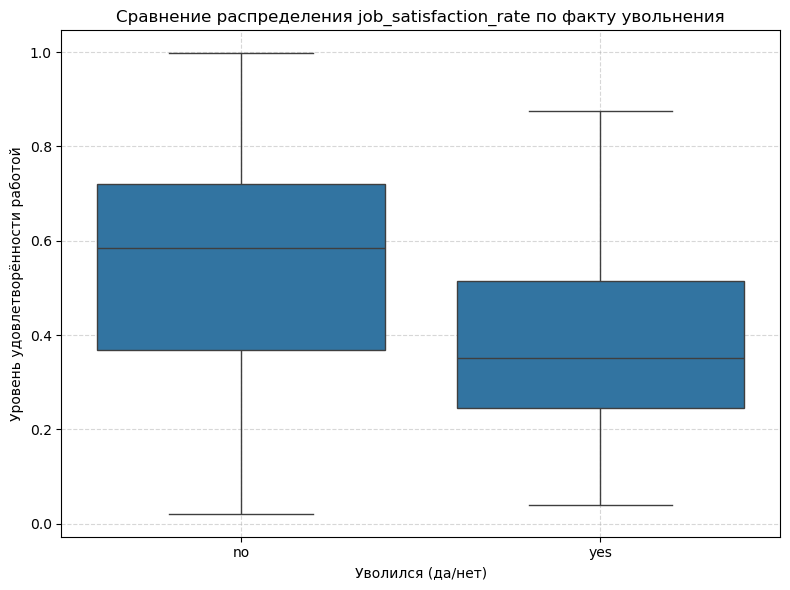

Медиана для уволившихся: 0.35
Медиана для оставшихся: 0.58


In [78]:
plt.figure(figsize=(8, 6))
sn.boxplot(x='quit', y='job_satisfaction_rate', data=train_new_s_rate)
plt.title('Сравнение распределения job_satisfaction_rate по факту увольнения')
plt.xlabel('Уволился (да/нет)')
plt.ylabel('Уровень удовлетворённости работой')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Вычисляем медианы
median_values = train_new_s_rate.groupby('quit')['job_satisfaction_rate'].median()

# Безопасный вывод с обработкой NaN
print(f"Медиана для уволившихся: {median_values.get('yes', float('nan')):.2f}")
print(f"Медиана для оставшихся: {median_values.get('no', float('nan')):.2f}")

Действительно, среди уволившихся сотрудников медианный уровень удовлетворенности работой 0.35, а среди неуволившихся 0.58. Поэтому мы можем сказать, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

Посмотрим, какой процент уволившихся сотрудников в разных категориях job_satisfaction_rate

In [79]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']
train_new_s_rate['satisfaction_category'] = pd.cut(train_new_s_rate['job_satisfaction_rate'], bins=bins, labels=labels, right=False)


In [80]:
yes_count = train_new_s_rate[train_new_s_rate['quit'] == 'yes'].groupby(
    'satisfaction_category', observed=True).size()

total_count = train_new_s_rate.groupby(
    'satisfaction_category', observed=True).size()
result_df = pd.DataFrame({
    'yes_count': yes_count,
    'total_count': total_count
}).fillna(0)

# Расчет процента увольнений
result_df['quit_percentage'] = (result_df['yes_count'] / result_df['total_count']) * 100
result_df = result_df.reset_index()

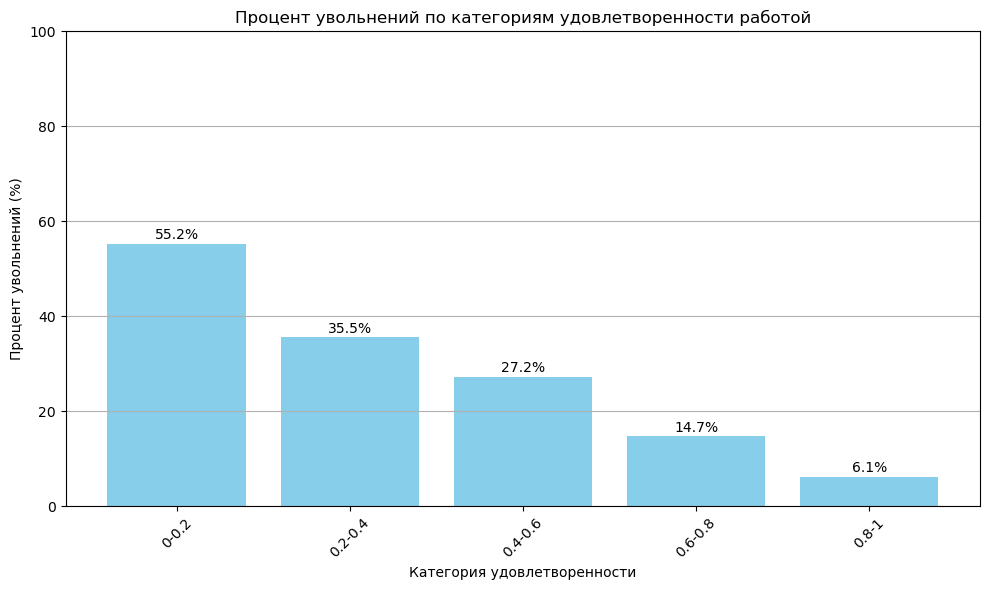

In [81]:
# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
plt.bar(result_df['satisfaction_category'], result_df['quit_percentage'], color='skyblue')
plt.title('Процент увольнений по категориям удовлетворенности работой')
plt.xlabel('Категория удовлетворенности')
plt.ylabel('Процент увольнений (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100) 
plt.grid(axis='y')

for index, value in enumerate(result_df['quit_percentage']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center')

plt.tight_layout()
plt.show()

Среди сотрудников с очень низким job_satisfaction_rate (от 0 до 0.2) максимальный процент (55.2%) уволившихся сотрудников, а среди наиболее удовлетворенных работой сотрудников c job_satisfaction_rate от 0.8 до 1 всего 6.1% уволившихся.

Посмотрим распредение зарплат для уволившихся и неуволившихся сотрудников.

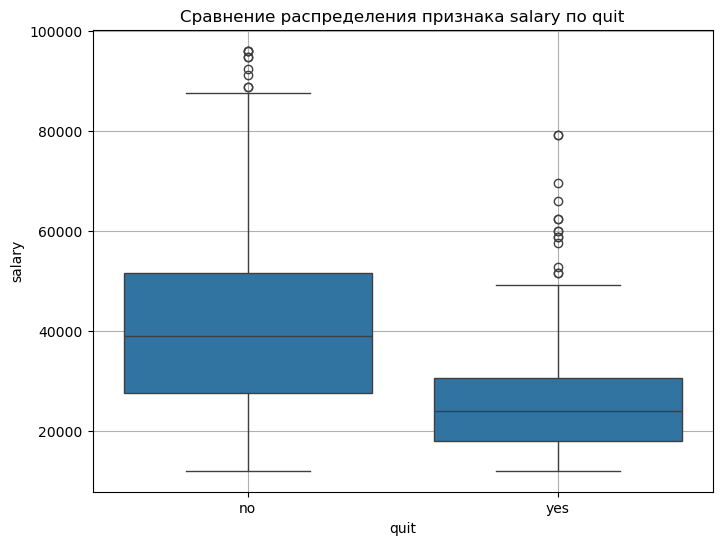

salary_yes_quit_stat:
count      655.000000
mean     25767.938931
std      10484.828614
min      12000.000000
25%      18000.000000
50%      24000.000000
75%      30600.000000
max      79200.000000
Name: salary, dtype: float64
salary_no_quit_stat:
count     1932.000000
mean     40952.173913
std      16085.739667
min      12000.000000
25%      27600.000000
50%      39000.000000
75%      51600.000000
max      96000.000000
Name: salary, dtype: float64


In [82]:
plt.figure(figsize=(8, 6))
sn.boxplot(x='quit', y='salary', data=train_new_s_rate)
plt.title('Сравнение распределения признака salary по quit')
plt.xlabel('quit')
plt.ylabel('salary')
plt.grid()
plt.show()

print('salary_yes_quit_stat:')
print(train_new_s_rate[train_new_s_rate['quit']=='yes']['salary'].describe())
print('salary_no_quit_stat:')
print(train_new_s_rate[train_new_s_rate['quit']=='no']['salary'].describe())

Зарплата также существенно влияет на то, уволится ли сотрудник. Медианная зарплата уволившихся сотрудников 24000, а неуволившихся 39000.В зоне риска сотрудники с зарплатой ниже 27600. 

Проведем корреляционный анализ признаков на следующем шаге после добавления нового признака job_satisfaction_rate.

**Выводы:**

Медианная заработная плата составляет 31200, в компании значительное разнообразии зарплат среди сотрудников, варьирующихся от 12000 до 98400. На диаграмме размаха видны выбросы, но их значения не выглядят аномальными, поэтому мы оставили их. 

Самый распространенный уровень middle 49.6%, далее идет junior c 37% и senior c 13.4%. Присутствие значительного количества сотрудников уровня middle говорит о том, что в компании есть достаточно специалистов со средним опытом, что может обеспечить стабильность и поддержку для новичков. 

Высокий процент сотрудников в отделе Sales (31.1%) указывает на то, что компания делает акцент на продажах и взаимодействии с клиентами.

Самый распространенный уровень загрузки 'medium' наблюдается у 48% сотрудников, далее идет 'low' c 29% и 'high' c 23%. Уровень 'high' (23%) может вызывать беспокойство, так как это означает, что значительное количество сотрудников испытывает высокую нагрузку, в то время как 29% сотрудниковв имеют низкую нагрузку.

Медиана стажа равна 3м годам, а среднее - 3.8 лет. Стандартное отклонение 2.6 лет говорит о разнообразии в длительности работы сотрудников.

За последний год только 4.3% сотрудников получали повышение, остальные 95.7% - нет. Это может указывать на то, что в компании ограниченные возможности для карьерного роста, либо отсутвует четкий и прозрачный карьерный трек и т.д.

Нарушение трудового договора имели 18.4% сотрудников. Возможно, трудовой договор имеет очень жесткие рамки, либо неясные условия.

Медианная оценка качества работы сотрудников равна 4 с небольшим стандартных отклонением 1. То, что 19.2% сотрудников демонстрируют низкую производительность (оценки 2 и 1), требует внимания и более глубокого анализа.

**Портрет «уволившегося сотрудника»:** 

 * уровня junior (56% сотрудников этого уровня уволились)
 * имеющие 1-3 года стажа (61% среди тех, у кого 1 год стажа, 42% - 2 года стажа, 39% - три года стажа )
 * имеющие низкие оценки качества работы 1-3 балла (40% среди тех, у кого 1 балл, 38% - 2 балла, 32% - 3 балла )
 * имеющие низкую нагрузку 'low' (39%)
 * имеющие нарушение трудового договора за последний год (38%)
 * не имеющие повышения за последний год (26%)
 * зарплата ниже 27600
 
Отдел почти не влияет на увольнение, в каждом отделе примерно одинаковое количество уволенных сотрудников. Чем меньше сотрудник удовлетворен работой, тем более вероятно, что он уволится. 
 
Среди сотрудников с очень низким job_satisfaction_rate (от 0 до 0.2) максимальный процент (55.2%) уволившихся сотрудников, а среди наиболее удовлетворенных работой сотрудников c job_satisfaction_rate от 0.8 до 1 всего 6.1% уволившихся. 

## Шаг 10. Добавление нового входного признака

На предыдущем шаге мы получили, что job_satisfaction_rate и quit действительно связаны. Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [83]:
train_new = train_new_s_rate.drop('satisfaction_category', axis=1).copy()

In [84]:
train_new.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.645163
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.836557
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.353317
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.321072
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.735699


In [85]:
X_test_new['job_satisfaction_rate']=best_model.predict(X_test_new)
X_test_new.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.845777
1,686555,hr,junior,medium,1,no,no,4,30000,0.673006
2,467458,sales,middle,low,5,no,no,4,19200,0.660495
3,418655,sales,middle,low,6,no,no,4,19200,0.657622
4,789145,hr,middle,medium,5,no,no,5,40800,0.818030


Проведем корреляционный анализ признаков.

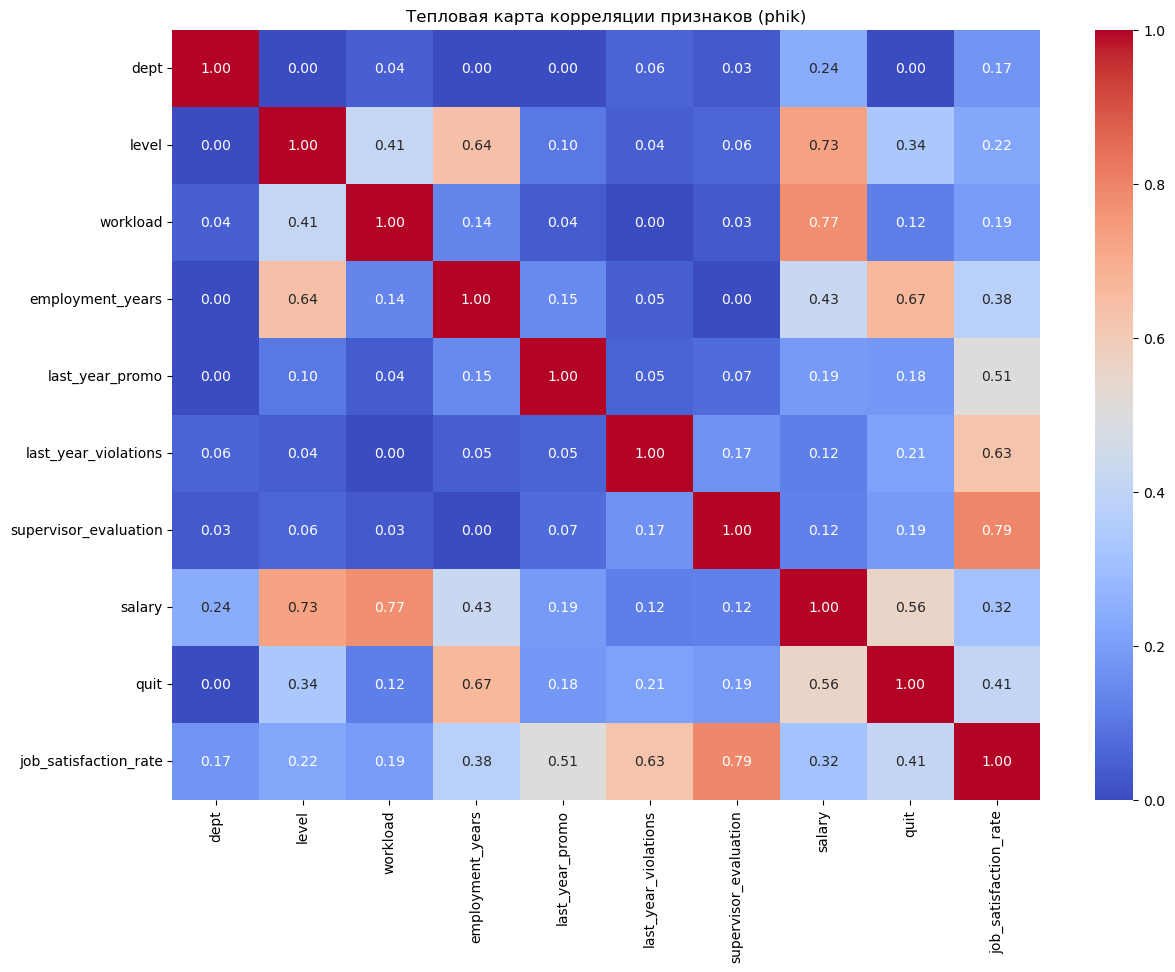

In [86]:
phik_corr = train_new.drop('id', axis=1).phik_matrix(
    interval_cols = [
    'employment_years', 
    'supervisor_evaluation', 
    'salary',
    'job_satisfaction_rate'
]
) 
plt.figure(figsize=(14, 10))
sn.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции признаков (phik)')
plt.show()

Между признаками наблюдается:


Сильная корреляция (значения выше 0.7):

* 0.77 - 'salary' и 'workload' 

* 0.79 - 'supervisor_evaluation' и 'job_satistfaction_rate'

* 0.73 - 'salary' и 'level'


Умеренная корреляция (значения от 0.4 до 0.7):
    
* 0.67 - 'employment_years' и 'quit'

* 0.64 - 'employment_years' и 'level'

* 0.63 - 'last_year_violations' и 'job_satistfaction_rate'

* 0.56 - 'salary' и 'quit'

* 0.43 - 'salary' и 'employment_years'

* 0.41 - 'level' и 'workload'

Слабая корреляция или отсутствие корреляции для остальных признаков, в том числе между признаком 'quit' и добавленным признаком 'job_satistfaction_rate' (0.39).

**Вывод: Добавлен признак 'job_satisfaction_rate' к входным признакам задачи 2. Проведен коррялицонный анализ для всех признаков. Между признаком 'quit' и добавленным признаком 'job_satistfaction_rate' присутствует слабая корреляция 0.39. Между признаками мультиколлинеарности не наблюдается.**

## Шаг 11. Подготовка данных

Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учтем особенности признаков и моделей и используем как минимум два кодировщика.

In [87]:
train_new.set_index('id', inplace=True)
X_test_new.set_index('id', inplace=True)
y_test_new.set_index('id', inplace=True)

In [88]:
y_train_new = train_new['quit']
X_train_new = train_new.drop('quit', axis = 1)

print(X_train_new.shape)
print(y_train_new.shape)
print(X_test_new.shape)
print(y_test_new.shape)

(2587, 9)
(2587,)
(2000, 9)
(2000, 1)


In [89]:
ohe_columns = ['dept',  'level', 'last_year_promo', 'last_year_violations']
ord_columns = ['workload', 'supervisor_evaluation']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate']
cat_list = ['dept',  'level', 'last_year_promo', 'last_year_violations','workload', 'supervisor_evaluation']

In [90]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_new)
y_test = label_encoder.transform(y_test_new.values.reshape(-1) )

ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
        
    ]
)
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),

(
            'ord',  
            OrdinalEncoder(
                categories='auto', 
                handle_unknown='use_encoded_value',
                unknown_value=6
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

data_preprocessor = ColumnTransformer(
    [ 
        ('num', MinMaxScaler(), num_columns),
        ('cat', ord_pipe, cat_list)
    ], 
    remainder='passthrough'
) 

**Вывод: Подготовлены данные для пайплайна.**

## Шаг 12. Обучение модели

Обучим как минимум три модели. Как минимум для двух из них подберем гиперпараметры. Проверим качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке. 

In [91]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [92]:
param_grid = [
        # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели DecisionTreeClassifier()
        {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__max_features': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели CatBoostClassifier()
        {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__max_depth': range(5,12),
        'models__iterations': [500, 1000],
        'models__learning_rate': [0.1, 0.5, 1, 5, 10]
    },
        {
        'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300, 500],
        'models__max_depth': [ 5, 10, 20, 30],
        'models__learning_rate':[ 0.1, 1, 5, 10 , 30]
    }

]

In [93]:
param_grid = [
    # LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear'
        )],
        'models__C': np.logspace(-3, 3, 7),  
        'models__penalty': ['l1', 'l2'],  
        'models__class_weight': [None, 'balanced'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    # DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [3, 5, 7, 9, 12, 15, None], 
        'models__min_samples_split': [2, 5, 10],  
        'models__min_samples_leaf': [1, 2, 4],  
        'models__max_features': ['sqrt', 'log2', None],  
        'preprocessor__num': ['passthrough'] 
    },
    
    # CatBoostClassifier
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__iterations': [300, 500, 700],  
        'models__learning_rate': [0.01, 0.03, 0.1, 0.3],  
        'models__depth': [4, 6, 8], 
        'models__l2_leaf_reg': [1, 3, 5], 
        'models__border_count': [32, 64, 128]  
    },
    
    # LGBMClassifier
    {
        'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300], 
        'models__num_leaves': [31, 63, 127],  
        'models__learning_rate': [0.01, 0.05, 0.1], 
        'models__min_child_samples': [20, 50, 100],  
        'models__reg_alpha': [0, 0.1, 1],  
        'models__reg_lambda': [0, 0.1, 1] 
    }
]

In [94]:
randomized_search_new = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_new.fit(X_train_new, y_train_new)

print('Лучшая модель и её параметры:\n\n', randomized_search_new.best_estimator_)
print ('Лучшие параметры:', randomized_search.best_params_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search_new.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['employment_years', 'salary',
                                                   'job_satisfaction_rate']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                                  ('simpleImputer_after_o

Таким образом, лучшая модель CatBoostClassifier.
Метрика лучшей модели при кросс-валидации: 0.923.

Посчитаем теперь метрику ROC-AUC на тестовой выборке.

In [95]:
X_test_new = X_test_new.join(y_test_new, how='outer')
test.shape

y_test_new = X_test_new['quit']
X_test_new = X_test_new.drop('quit', axis = 1)

In [96]:
y_pred_proba = randomized_search_new.predict_proba(X_test_new)
y_pred = randomized_search_new.predict(X_test_new)
y_prob_positive = y_pred_proba[:, 1]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_new, y_prob_positive)}')

Метрика ROC-AUC на тестовой выборке: 0.9314678035915367


Критерий успеха ROC-AUC ≥0.91 на тестовой выборке выполнен.

**Построим ROC-кривую модели.**

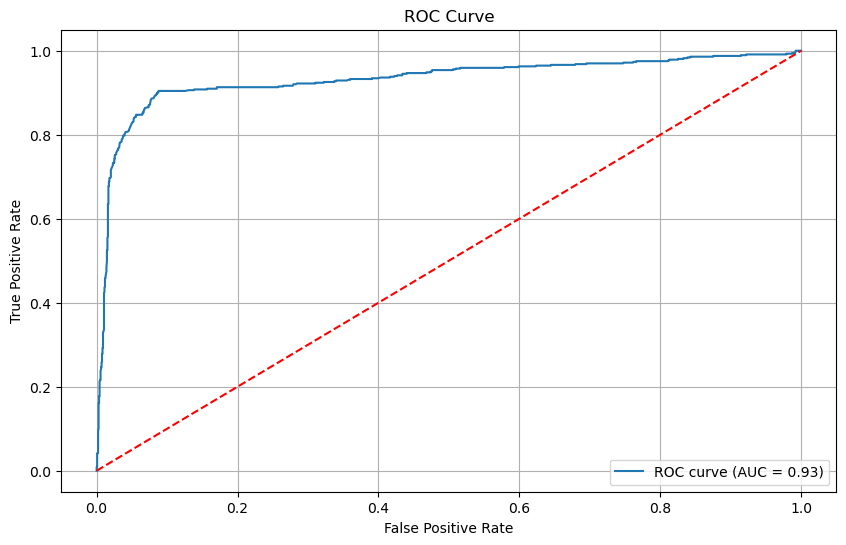

In [97]:
y_test_binary = [1 if label == 'yes' else 0 for label in y_test_new]
fpr, tpr, _ = roc_curve(y_test_binary, y_prob_positive)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'r--')  # Линия случайного угадывания
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

По оси True Positive Rate наблюдается очень хорошая чувствительность модели (доля истинно положительных случаев), по оси False Positive Rate можно отметить хорошую специфичность. Площадь под ROC кривой говорит о том, что модель хорошо различает классы. Сравнение с DummyModel (y=x красная пунктирная линия) говорит о том, что случайное угадывание работает несопоставимо хуже выбранной обученной модели.

**Построим матрицу ошибок**

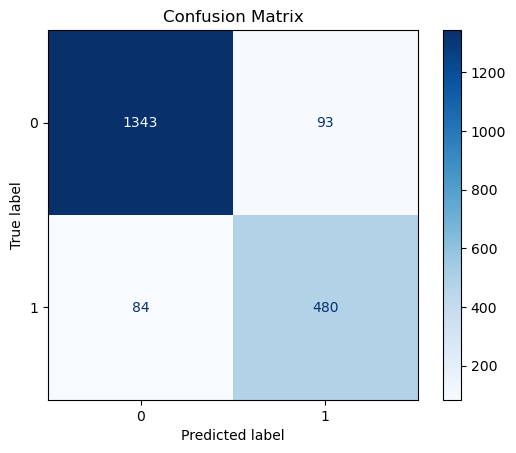

In [98]:
y_pred_binary = [1 if label == 'yes' else 0 for label in y_pred]
cm = confusion_matrix(y_test_binary, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Модель для 1343 сотрудников верно предсказала, что он продолжит работать, для 480 пользователей верно предсказала, что сотрудник уйдет. Модель неверно предсказала для 84 сотрудников, что они останутся, и для 93 неверно предсказала, что сотрудник уйдет, тогда как он остался. Взависимости от задачи HR, можно использовать разный порог классификации (любой менее 0.5, например, 0.3) и охватить большее количество сотрудников, которые могут уйти.

**Вывод:** Мы  обучили 4 модели с различными гиперпараметрами LogisticRegression, DecisionTreeClassifier, CatBoostClassifier и LGBMClassifier. Лучшей моделью оказалась модель CatBoostClassifier.
Метрика лучшей модели при кросс-валидации: 0.923. На тестовой выборке получена метрика, равную 0.931. Таким образом, критерий успеха ROC-AUC ≥0.91 на тестовой выборке выполнен.

## Шаг 13. Промежуточные выводы по задаче 2

CatBoost оказалось лучшей моделью благодаря автоматической работе с категория,защите от переобучения и оптимальному балансу сложности . На тестовой выборке была получена метрика, равная 0.931.

## Шаг 14. Общий вывод и предложения для бизнеса

### Общий вывод

**Портрет «уволившегося сотрудника»:** 

 * уровня junior (56% сотрудников этого уровня уволились)
 * имеющие 1-3 года стажа (61% среди тех, у кого 1 год стажа, 42% - 2 года стажа, 39% - три года стажа )
 * имеющие низкие оценки качества работы 1-3 балла (40% среди тех, у кого 1 балл, 38% - 2 балла, 32% - 3 балла )
 * имеющие низкую нагрузку 'low' (39%)
 * имеющие нарушение трудового договора за последний год (38%)
 * не имеющие повышения за последний год (26%)
 * зарплата ниже 27600
 
Отдел почти не влияет на увольнение. 

Чем меньше сотрудник удовлетворен работой, тем более вероятно, что он уволится. Среди сотрудников с очень низким job_satisfaction_rate (от 0 до 0.2) максимальный процент (55.2%) уволившихся сотрудников, а среди наиболее удовлетворенных работой сотрудников c job_satisfaction_rate от 0.8 до 1 всего 6.1% уволившихся. 

Самый распространенный уровень 'junior' 45.3%, вероятно, есть недостаток специалистов с высоким уровнем компетенций. 

Почти четверть сотрудников (22.6%) работает в компании всего 1 год, что может указывать на высокую текучесть кадров, проблемы с удержанием сотрудников.

За последний год только 3% сотрудников получали повышение, остальные 97% - нет. Вероятно, в компании ограниченные возможности для карьерного роста.

**Задача 1.** Была разработана регрессионная модель предсказания уровня удовлетворённости сотрудника на основе данных заказчика с точностью SMAPE =10.6%.

**Задача 2.** Была разработана модель классификации, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании с метрикой ROC-AUC=0.93. Взависимости от задачи HR, можно использовать разный порог классификации (любой менее 0.5, например, 0.3) и охватить большее количество сотрудников, которые могут уйти, предлагая им различные опции\возможности для удержания.

### Предложения для бизнеса

На основании проведенного анализа данных можно сделать несколько выводов и предложений для бизнеса, которые могут помочь улучшить ситуацию в компании и повысить удовлетворенность сотрудников.

**По задаче 1.**

▎Выводы:

1. Разнообразие заработной платы: Значительный разброс в зарплатах может указывать на несоответствие между уровнями компетенций и вознаграждением, что может негативно сказываться на мотивации сотрудников.

2. Неоднородность уровня удовлетворенности: Разные уровни удовлетворенности сотрудников могут свидетельствовать о проблемах в управлении персоналом или корпоративной культуре.

3. Структура отделов: Высокая доля сотрудников в отделе продаж может означать, что компания делает акцент на продажах, однако малое количество сотрудников в HR может указывать на недостаточное внимание к управлению человеческими ресурсами.

4. Нехватка опытных специалистов: Высокое соотношение junior и middle специалистов к senior может означать, что компания не привлекает достаточно опытных кадров, что может ограничивать ее рост и развитие.

5. Высокая текучесть кадров: Большая доля сотрудников, работающих менее года, и снижение процента сотрудников с увеличением стажа указывают на проблемы с удержанием кадров.

6. Ограниченные возможности карьерного роста: Низкий процент повышения зарплат и продвижения по службе может свидетельствовать о недостаточно развитой системе карьерного роста.

7. Нарушение трудового договора: 15% сотрудников с нарушениями трудового договора могут указывать на проблемы с управлением условиями труда.

8. Оценка качества работы: Разнообразие оценок качества работы сотрудников показывает, что есть потенциал для повышения эффективности работы и развития отдельных сотрудников.

▎Предложения:

1. Пересмотр системы оплаты труда:

   • Провести анализ рынка труда для определения конкурентоспособности заработной платы.

   • Внедрить более прозрачную систему вознаграждений, основанную на результатах работы и уровне компетенций.
   

2. Улучшение удовлетворенности сотрудников:

   • Провести опросы для выявления причин низкой удовлетворенности.

   • Разработать программы по повышению вовлеченности сотрудников, такие как тимбилдинги, тренинги и другие мероприятия.
   

3. Увеличение численности HR-отдела:

   • Увеличить число сотрудников в HR для улучшения управления персоналом и повышения уровня удержания сотрудников.
   

4. Создание системы карьерного роста:

   • Внедрить четкие карьерные треки с возможностью повышения и развития навыков для всех уровней сотрудников.

   • Рассмотреть возможность менторства для junior и middle специалистов от senior.
   

5. Анализ текучести кадров:

   • Провести анализ причин увольнений и разработать стратегию удержания сотрудников.

   • Рассмотреть возможность введения программ лояльности для долгосрочных сотрудников.
   

6. Работа с трудовыми договорами:

   • Пересмотреть условия трудовых договоров для их упрощения и большей ясности.

   • Обеспечить обучение по вопросам соблюдения трудовых договоров.
   

7. Повышение качества работы:

   • Внедрить регулярные оценки эффективности работы с возможностью обратной связи и планами по развитию.

   • Разработать программы обучения и повышения квалификации для сотрудников с низкими оценками.
   

Внедрение этих предложений может помочь компании улучшить рабочую атмосферу, повысить удовлетворенность сотрудников и снизить текучесть кадров, что в свою очередь положительно скажется на производительности и росте бизнеса.


**По задаче 2.**

▎Выводы:

1. Разнообразие заработной платы: Медианная зарплата составляет 31200, но существует значительный разброс от 12000 до 98400. Это может создать недовольство среди тех сотрудников, кто получает меньшую зарплату.

2. Структура уровней сотрудников: Преобладание специалистов уровня middle (49.6%) и наличие junior (37%) указывает на то, что в компании есть стабильная база, но недостаток senior (13.4%) может ограничивать возможности для наставничества и развития.

3. Фокус на продажах: Высокий процент сотрудников в отделе Sales (31.1%) говорит о сильном акценте на продажи.

4. Нагрузка сотрудников: Уровень загрузки 'high' у 23% сотрудников может привести к выгоранию и снижению производительности, в то время как 29% имеют низкую загрузку, что может указывать на неэффективное распределение задач.

5. Ограниченные возможности карьерного роста: Только 4.3% сотрудников получили повышение за последний год, что может свидетельствовать о недостатке прозрачности в карьерных возможностях и мотивации для развития.

6. Нарушение трудового договора: 18.4% сотрудников столкнулись с нарушениями трудового договора, что может указывать на неясные условия или жесткие рамки, требующие пересмотра.

7. Качество работы: Медианная оценка качества работы равна 4, но 19.2% сотрудников показывают низкую производительность (оценки 1-2), что требует внимания к процессам оценки и обучения.

8. Текучесть кадров среди junior сотрудников: Высокий процент увольнений среди junior сотрудников (56%) указывает на проблемы с удержанием новичков, особенно тех, кто имеет низкие оценки качества работы и низкий уровень удовлетворенности.

9. Влияние удовлетворенности на текучесть: Низкий уровень удовлетворенности работы (job satisfaction rate) напрямую влияет на вероятность увольнения.

▎Предложения:

1. Пересмотр системы оплаты труда:

   • Провести анализ заработной платы и изучить возможность внедрения более прозрачной системы вознаграждений, системы премий и бонусов, особенно для специалистов с зарплатой ниже 27600.
   

2. Создание карьерных треков:

   • Разработать четкие карьерные пути и возможности для повышения, чтобы сотрудники знали, как они могут развиваться внутри компании.

   • Внедрить программы менторства для junior и middle сотрудников с участием senior специалистов.
   

3. Управление нагрузкой:

   • Провести анализ распределения задач и рассмотреть возможность перераспределения нагрузки между сотрудниками.

   • Внедрить механизмы поддержки для сотрудников с высокой нагрузкой, такие как гибкие графики или дополнительные ресурсы.
   

4. Улучшение условий труда:

   • Пересмотреть условия трудовых договоров для устранения неясностей и жестких рамок.

   • Обеспечить регулярные обратные связи по условиям труда и удовлетворенности сотрудников.
   

5. Программы повышения качества работы:

   • Внедрить регулярные оценки производительности с возможностью обратной связи и планами по развитию для сотрудников с низкими оценками.

   • Разработать программы обучения и повышения квалификации для улучшения производительности сотрудников.
   

6. Фокус на удержание junior сотрудников:

   • Провести опросы среди увольняющихся сотрудников для выявления причин увольнений и разработать стратегии удержания.

   • Создать программы адаптации для новых сотрудников, чтобы помочь им быстрее интегрироваться в команду.
   

7. Улучшение уровня удовлетворенности:

   • Регулярно проводить опросы по удовлетворенности работы и реагировать на результаты, внедряя изменения на основе отзывов сотрудников.

   • Организовать календарь мероприятий для повышения командного духа и вовлеченности сотрудников.
   
